In [2]:
# Uncomment the commented-out lines in this cell when generating ELMo embeddings to avoid excess warning messages.
import gc
import glob
import string
import functools
import operator
import spacy
import jsonlines
import matplotlib.pyplot as plt
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
# tf.get_logger().setLevel('ERROR')
# tf.logging.set_verbosity(tf.logging.ERROR)
# tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import tensorflow_hub as hub
from scipy.optimize import minimize
from Utils import *

In [6]:
fs = glob.glob(data_dir + wiki_dir + "*.jsonl")
punc_trans = str.maketrans('', '', string.punctuation)
test_claim_ids = [75397, 150448, 214861, 156709, 129629, 33078, 6744, 226034, 40190, 76253]

In [7]:
# Load claims (can load n non-test samples, loads the 10 test samples by default)
# nlp = spacy.load('en', disable=['tagger', 'parser', 'ner', 'entity_linker', 'textcat', 'entity_ruler', 'sentencizer'])
def load_claims(n=1000, offs=0, test=False):
    claims = []
    claims_vocab = set()
    i_ = 0
    with open(data_dir + "train.jsonl", 'r') as f:
        for a_ in jsonlines.Reader(f):
            if (a_["id"] in test_claim_ids) ^ (not test):
                i_ += 1
                if i_ <= offs:
                    continue
                claims.append(a_)
                claims[-1]["vocab"] = defaultdict(int)
                for w in a_["claim"].replace('-LRB-', '').replace('-RRB-', '').replace("'s", ''). \
                  translate(punc_trans).lower().split():
#                     w = [token.lemma_ for token in nlp(w)][0]
                    claims[-1]["vocab"][w] += 1
                    claims_vocab.add(w)
            if i_ == n + offs:
                break
    return claims, claims_vocab
claims, claims_vocab = load_claims()
N_claims = len(claims)
N_claims

1000

In [59]:
# Load documents and collect term frequencies
def load_line(l):
#     nlp = spacy.load('en', disable=['tagger', 'parser', 'ner', 'entity_linker', 'textcat', 'entity_ruler', 'sentencizer'])
#     return [token.lemma_ for token in nlp(' '.join([
#         w.translate(punc_trans).lower() for w in l.split()[1:] if w != \
#          '' and not ((any(c.isnumeric() for c in w) and len(w) > 7) or \
#                      (w.isnumeric() and len(w) > 5))]))]
#     nlp = spacy.load('en', disable=['tagger', 'parser', 'ner', 'entity_linker', 'textcat', 'entity_ruler', 'sentencizer'])
    return [
        w.translate(punc_trans).lower() for w in l.split()[1:] if w != \
         '' and not ((any(c.isnumeric() for c in w) and len(w) > 7) or \
                     (w.isnumeric() and len(w) > 5))]
def load_docs(vocab, load_tf=False):
    i_ = 0
    wiki = {}
    n_t = defaultdict(int)
    if load_tf: tfs = defaultdict(int)
    for fn in fs:
        ids_ = []
        all_lines = []
        with open(fn, 'r') as f:
            for a_ in jsonlines.Reader(f):
                if a_["id"] == "" or a_["lines"] == "":
                    continue
                ids_.append(a_["id"])
                all_lines.append((a_["id"], ' '.join([l for l in a_[
                        "lines"].replace('-LRB-', '').replace('-RRB-', '').replace("'s", '').split('\n') if \
                         len(l.split(' ')) > 0 and not (len(l.split(' ')) == 1 and l.strip().isnumeric())])))
        print(len(all_lines))
        all_lines_ = joblib.Parallel(n_jobs=n_cpu, verbose=5)(delayed(load_line)(l) for _, l in all_lines)
#                 l_i = -1
        
        for i in range(len(ids_)):
            id_ = ids_[i]
            l = all_lines_[i]
#                     l_i += 1
#                     if len(l) == 0:
#                         print(a_[
#                         "lines"].replace('-LRB-', '').replace('-RRB-', '').replace("'s", '').split('\n')[l_i])
            doc_tf = defaultdict(int)
            total = 0
            for w in l:
                if load_tf: tfs[w] += 1
                if w in vocab:
                    doc_tf[w] += 1
                total += 1
            if total == 0: continue
            for w in set(l):
                n_t[w] += 1
            wiki[id_] = l, doc_tf, total
        i_ += 1
        if i_ % 100 == 0:
            print("\r" + str(i_) + " / " + str(len(fs)))
    if load_tf:
        return tfs, wiki, n_t
    return wiki, n_t
tfs, wiki, n_t = load_docs(claims_vocab, load_tf=True)

49174


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:   44.4s
[Parallel(n_jobs=96)]: Done 258 tasks      | elapsed:   44.6s
[Parallel(n_jobs=96)]: Done 456 tasks      | elapsed:   44.8s
[Parallel(n_jobs=96)]: Done 708 tasks      | elapsed:   45.0s
[Parallel(n_jobs=96)]: Done 1440 tasks      | elapsed:   45.3s
[Parallel(n_jobs=96)]: Done 3648 tasks      | elapsed:   45.7s
[Parallel(n_jobs=96)]: Done 9120 tasks      | elapsed:   46.3s
[Parallel(n_jobs=96)]: Done 15168 tasks      | elapsed:   47.1s
[Parallel(n_jobs=96)]: Done 21792 tasks      | elapsed:   47.8s
[Parallel(n_jobs=96)]: Done 28992 tasks      | elapsed:   48.6s
[Parallel(n_jobs=96)]: Done 36768 tasks      | elapsed:   49.4s
[Parallel(n_jobs=96)]: Done 45120 tasks      | elapsed:   50.3s
[Parallel(n_jobs=96)]: Done 48288 tasks      | elapsed:   51.0s
[Parallel(n_jobs=96)]: Done 48882 tasks      | elapsed:   51.6s
[Parallel(n_jobs=96)]: Done 49174 out 

49936


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  97 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 326 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 726 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done 1688 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3856 tasks      | elapsed:    1.2s
[Parallel(n_jobs=96)]: Done 8752 tasks      | elapsed:    1.8s
[Parallel(n_jobs=96)]: Done 14224 tasks      | elapsed:    2.4s
[Parallel(n_jobs=96)]: Done 20272 tasks      | elapsed:   20.5s
[Parallel(n_jobs=96)]: Done 22658 tasks      | elapsed:   20.9s
[Parallel(n_jobs=96)]: Done 24920 tasks      | elapsed:   21.4s
[Parallel(n_jobs=96)]: Done 31696 tasks      | elapsed:   22.2s
[Parallel(n_jobs=96)]: Done 40048 tasks      | elapsed:   23.0s
[Parallel(n_jobs=96)]: Done 48916 tasks      | elapsed:   23.8s
[Parallel(n_jobs=96)]: Done 49555 tasks      | elapsed:   24.4s
[Parallel(n_jobs=96)]: Done 49936 ou

49924


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 1416 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3264 tasks      | elapsed:    1.2s
[Parallel(n_jobs=96)]: Done 5712 tasks      | elapsed:    1.6s
[Parallel(n_jobs=96)]: Done 8448 tasks      | elapsed:    2.1s
[Parallel(n_jobs=96)]: Done 11472 tasks      | elapsed:    2.6s
[Parallel(n_jobs=96)]: Done 14784 tasks      | elapsed:    3.2s
[Parallel(n_jobs=96)]: Done 18384 tasks      | elapsed:    3.9s
[Parallel(n_jobs=96)]: Done 22272 tasks      | elapsed:    4.5s
[Parallel(n_jobs=96)]: Done 26448 tasks      | elapsed:    5.3s
[Parallel(n_jobs=96)]: Done 30912 tasks      | elapsed:    6.0s
[Parallel(n_jobs=96)]: Done 35664 tasks      | elapsed:    6.8s
[Parallel(n_jobs=96)]: Done 40704 tas

49936


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  97 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 326 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 870 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 2264 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 6000 tasks      | elapsed:    1.3s
[Parallel(n_jobs=96)]: Done 15776 tasks      | elapsed:    2.0s
[Parallel(n_jobs=96)]: Done 26720 tasks      | elapsed:    2.7s
[Parallel(n_jobs=96)]: Done 38816 tasks      | elapsed:    3.4s
[Parallel(n_jobs=96)]: Done 49057 tasks      | elapsed:    4.2s
[Parallel(n_jobs=96)]: Done 49507 tasks      | elapsed:    4.6s
[Parallel(n_jobs=96)]: Done 49936 out of 49936 | elapsed:    4.9s finished


49905


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.4s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done 1416 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3264 tasks      | elapsed:    1.2s
[Parallel(n_jobs=96)]: Done 5712 tasks      | elapsed:    1.6s
[Parallel(n_jobs=96)]: Done 8448 tasks      | elapsed:    2.1s
[Parallel(n_jobs=96)]: Done 11472 tasks      | elapsed:    2.6s
[Parallel(n_jobs=96)]: Done 14784 tasks      | elapsed:    3.1s
[Parallel(n_jobs=96)]: Done 18384 tasks      | elapsed:    3.7s
[Parallel(n_jobs=96)]: Done 22272 tasks      | elapsed:    4.3s
[Parallel(n_jobs=96)]: Done 26448 tasks      | elapsed:    5.0s
[Parallel(n_jobs=96)]: Done 30912 tasks      | elapsed:    5.7s
[Parallel(n_jobs=96)]: Done 35664 tasks      | elapsed:    6.5s
[Parallel(n_jobs=96)]: Done 40704 tas

49920


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 1416 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3264 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 8160 tasks      | elapsed:    1.6s
[Parallel(n_jobs=96)]: Done 13632 tasks      | elapsed:    2.1s
[Parallel(n_jobs=96)]: Done 19680 tasks      | elapsed:    2.6s
[Parallel(n_jobs=96)]: Done 26304 tasks      | elapsed:    3.2s
[Parallel(n_jobs=96)]: Done 33504 tasks      | elapsed:    3.9s
[Parallel(n_jobs=96)]: Done 41280 tasks      | elapsed:    4.6s
[Parallel(n_jobs=96)]: Done 49362 tasks      | elapsed:    5.4s
[Parallel(n_jobs=96)]: Done 49920 out of 49920 | elapsed:    5.8s finished


49904


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 1416 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3264 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 7712 tasks      | elapsed:    1.6s
[Parallel(n_jobs=96)]: Done 24000 tasks      | elapsed:    2.5s
[Parallel(n_jobs=96)]: Done 44306 tasks      | elapsed:    3.4s
[Parallel(n_jobs=96)]: Done 46848 tasks      | elapsed:    3.9s
[Parallel(n_jobs=96)]: Done 49904 out of 49904 | elapsed:    4.4s finished


48178


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.4s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done 1420 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3264 tasks      | elapsed:    1.2s
[Parallel(n_jobs=96)]: Done 8160 tasks      | elapsed:    1.6s
[Parallel(n_jobs=96)]: Done 13632 tasks      | elapsed:    2.1s
[Parallel(n_jobs=96)]: Done 19680 tasks      | elapsed:    2.7s
[Parallel(n_jobs=96)]: Done 26304 tasks      | elapsed:    3.3s
[Parallel(n_jobs=96)]: Done 33504 tasks      | elapsed:    4.0s
[Parallel(n_jobs=96)]: Done 41280 tasks      | elapsed:    4.7s
[Parallel(n_jobs=96)]: Done 47922 tasks      | elapsed:    5.4s
[Parallel(n_jobs=96)]: Done 48178 out of 48178 | elapsed:    5.5s finished


49928


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 1420 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3272 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 9984 tasks      | elapsed:    1.7s
[Parallel(n_jobs=96)]: Done 29376 tasks      | elapsed:    2.6s
[Parallel(n_jobs=96)]: Done 49410 tasks      | elapsed:    3.5s
[Parallel(n_jobs=96)]: Done 49928 out of 49928 | elapsed:    3.9s finished


49948


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 325 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 864 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 2256 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 5952 tasks      | elapsed:    1.2s
[Parallel(n_jobs=96)]: Done 15744 tasks      | elapsed:    1.8s
[Parallel(n_jobs=96)]: Done 26688 tasks      | elapsed:    2.5s
[Parallel(n_jobs=96)]: Done 38784 tasks      | elapsed:    3.3s
[Parallel(n_jobs=96)]: Done 49056 tasks      | elapsed:    4.0s
[Parallel(n_jobs=96)]: Done 49506 tasks      | elapsed:    4.4s
[Parallel(n_jobs=96)]: Done 49948 out of 49948 | elapsed:    4.7s finished


49899


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  97 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 326 tasks      | elapsed:    0.4s
[Parallel(n_jobs=96)]: Done 722 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done 1420 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3272 tasks      | elapsed:    1.2s
[Parallel(n_jobs=96)]: Done 5720 tasks      | elapsed:    1.6s
[Parallel(n_jobs=96)]: Done 8456 tasks      | elapsed:    2.0s
[Parallel(n_jobs=96)]: Done 11480 tasks      | elapsed:    2.5s
[Parallel(n_jobs=96)]: Done 14792 tasks      | elapsed:    3.0s
[Parallel(n_jobs=96)]: Done 18392 tasks      | elapsed:    3.6s
[Parallel(n_jobs=96)]: Done 22280 tasks      | elapsed:    4.2s
[Parallel(n_jobs=96)]: Done 28144 tasks      | elapsed:    4.9s
[Parallel(n_jobs=96)]: Done 37072 tasks      | elapsed:    5.8s
[Parallel(n_jobs=96)]: Done 46576 tasks      | elapsed:    6.7s
[Parallel(n_jobs=96)]: Done 49899 out

49946


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done 103 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 338 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 894 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 2312 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 6064 tasks      | elapsed:    1.2s
[Parallel(n_jobs=96)]: Done 10960 tasks      | elapsed:    1.7s
[Parallel(n_jobs=96)]: Done 16432 tasks      | elapsed:    2.2s
[Parallel(n_jobs=96)]: Done 22480 tasks      | elapsed:    2.7s
[Parallel(n_jobs=96)]: Done 29104 tasks      | elapsed:    3.3s
[Parallel(n_jobs=96)]: Done 36304 tasks      | elapsed:    4.0s
[Parallel(n_jobs=96)]: Done 44080 tasks      | elapsed:    4.8s
[Parallel(n_jobs=96)]: Done 49177 tasks      | elapsed:    5.4s
[Parallel(n_jobs=96)]: Done 49735 tasks      | elapsed:    5.9s
[Parallel(n_jobs=96)]: Done 49946 out of 49946 | elapsed:    6.0s finished


49928


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done 1224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 2688 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 5136 tasks      | elapsed:    1.5s
[Parallel(n_jobs=96)]: Done 7872 tasks      | elapsed:    1.9s
[Parallel(n_jobs=96)]: Done 10896 tasks      | elapsed:    2.4s
[Parallel(n_jobs=96)]: Done 14208 tasks      | elapsed:    2.9s
[Parallel(n_jobs=96)]: Done 17808 tasks      | elapsed:    3.5s
[Parallel(n_jobs=96)]: Done 21696 tasks      | elapsed:    4.1s
[Parallel(n_jobs=96)]: Done 25872 tasks      | elapsed:    4.8s
[Parallel(n_jobs=96)]: Done 30336 tasks      | elapsed:    5.5s
[Parallel(n_jobs=96)]: Done 35088 tasks      | elapsed:    6.2s
[Parallel(n_jobs=96)]: Done 40128 tas

49899


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  97 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 326 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 868 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 2264 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 5984 tasks      | elapsed:    1.2s
[Parallel(n_jobs=96)]: Done 15776 tasks      | elapsed:    1.9s
[Parallel(n_jobs=96)]: Done 26720 tasks      | elapsed:    2.5s
[Parallel(n_jobs=96)]: Done 38816 tasks      | elapsed:   24.1s
[Parallel(n_jobs=96)]: Done 43394 tasks      | elapsed:   24.6s
[Parallel(n_jobs=96)]: Done 45080 tasks      | elapsed:   25.1s
[Parallel(n_jobs=96)]: Done 48968 tasks      | elapsed:   25.8s
[Parallel(n_jobs=96)]: Done 49651 tasks      | elapsed:   26.3s
[Parallel(n_jobs=96)]: Done 49899 out of 49899 | elapsed:   26.4s finished


49954


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.4s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done 1416 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3272 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 9984 tasks      | elapsed:    1.7s
[Parallel(n_jobs=96)]: Done 29376 tasks      | elapsed:    2.7s
[Parallel(n_jobs=96)]: Done 49410 tasks      | elapsed:    3.6s
[Parallel(n_jobs=96)]: Done 49954 out of 49954 | elapsed:    4.0s finished


49954


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 1416 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3264 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 7392 tasks      | elapsed:    1.6s
[Parallel(n_jobs=96)]: Done 12864 tasks      | elapsed:    2.1s
[Parallel(n_jobs=96)]: Done 18912 tasks      | elapsed:    2.6s
[Parallel(n_jobs=96)]: Done 25536 tasks      | elapsed:    3.3s
[Parallel(n_jobs=96)]: Done 32736 tasks      | elapsed:    3.9s
[Parallel(n_jobs=96)]: Done 40512 tasks      | elapsed:    4.7s
[Parallel(n_jobs=96)]: Done 48594 tasks      | elapsed:    5.4s
[Parallel(n_jobs=96)]: Done 49152 tasks      | elapsed:    6.0s
[Parallel(n_jobs=96)]: Done 49746 tasks      | elapsed:    6.5s
[Parallel(n_jobs=96)]: Done 49954 ou

49905


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  97 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 326 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 722 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done 1424 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3288 tasks      | elapsed:    1.2s
[Parallel(n_jobs=96)]: Done 10016 tasks      | elapsed:    1.7s
[Parallel(n_jobs=96)]: Done 20960 tasks      | elapsed:    2.4s
[Parallel(n_jobs=96)]: Done 33056 tasks      | elapsed:    3.2s
[Parallel(n_jobs=96)]: Done 46304 tasks      | elapsed:    4.1s
[Parallel(n_jobs=96)]: Done 49699 tasks      | elapsed:    4.6s
[Parallel(n_jobs=96)]: Done 49905 out of 49905 | elapsed:    4.7s finished


49696


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.4s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done 1416 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3264 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 7392 tasks      | elapsed:    1.6s
[Parallel(n_jobs=96)]: Done 12864 tasks      | elapsed:    2.1s
[Parallel(n_jobs=96)]: Done 18912 tasks      | elapsed:    2.7s
[Parallel(n_jobs=96)]: Done 25536 tasks      | elapsed:    3.3s
[Parallel(n_jobs=96)]: Done 32736 tasks      | elapsed:    4.0s
[Parallel(n_jobs=96)]: Done 40512 tasks      | elapsed:    4.7s
[Parallel(n_jobs=96)]: Done 48579 tasks      | elapsed:    5.5s
[Parallel(n_jobs=96)]: Done 49152 tasks      | elapsed:    6.1s
[Parallel(n_jobs=96)]: Done 49696 out of 49696 | elapsed:    6.5s finished


49849


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 722 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 1680 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3840 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 6288 tasks      | elapsed:    1.5s
[Parallel(n_jobs=96)]: Done 9024 tasks      | elapsed:    1.9s
[Parallel(n_jobs=96)]: Done 12048 tasks      | elapsed:    2.4s
[Parallel(n_jobs=96)]: Done 15360 tasks      | elapsed:    2.9s
[Parallel(n_jobs=96)]: Done 18960 tasks      | elapsed:    3.5s
[Parallel(n_jobs=96)]: Done 22848 tasks      | elapsed:    4.1s
[Parallel(n_jobs=96)]: Done 27024 tasks      | elapsed:    4.8s
[Parallel(n_jobs=96)]: Done 31488 tasks      | elapsed:    5.5s
[Parallel(n_jobs=96)]: Done 39456 tasks      | elapsed:    6.4s
[Parallel(n_jobs=96)]: Done 48441 tas

49912


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.4s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done 1226 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 2688 tasks      | elapsed:    1.2s
[Parallel(n_jobs=96)]: Done 5136 tasks      | elapsed:    1.6s
[Parallel(n_jobs=96)]: Done 7872 tasks      | elapsed:    2.0s
[Parallel(n_jobs=96)]: Done 10896 tasks      | elapsed:    2.5s
[Parallel(n_jobs=96)]: Done 14208 tasks      | elapsed:    3.0s
[Parallel(n_jobs=96)]: Done 17808 tasks      | elapsed:    3.6s
[Parallel(n_jobs=96)]: Done 21696 tasks      | elapsed:    4.2s
[Parallel(n_jobs=96)]: Done 25872 tasks      | elapsed:    4.8s
[Parallel(n_jobs=96)]: Done 30336 tasks      | elapsed:    5.6s
[Parallel(n_jobs=96)]: Done 35088 tasks      | elapsed:    6.3s
[Parallel(n_jobs=96)]: Done 40128 tas

49896


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 325 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 864 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 2256 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 5952 tasks      | elapsed:    1.2s
[Parallel(n_jobs=96)]: Done 10848 tasks      | elapsed:    1.7s
[Parallel(n_jobs=96)]: Done 16320 tasks      | elapsed:    2.2s
[Parallel(n_jobs=96)]: Done 22368 tasks      | elapsed:    2.9s
[Parallel(n_jobs=96)]: Done 28992 tasks      | elapsed:    3.5s
[Parallel(n_jobs=96)]: Done 36192 tasks      | elapsed:    4.3s
[Parallel(n_jobs=96)]: Done 43968 tasks      | elapsed:    5.2s
[Parallel(n_jobs=96)]: Done 49170 tasks      | elapsed:    5.9s
[Parallel(n_jobs=96)]: Done 49896 out of 49896 | elapsed:    6.5s finished


49921


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  97 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 326 tasks      | elapsed:    0.4s
[Parallel(n_jobs=96)]: Done 722 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done 1228 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 2696 tasks      | elapsed:    1.2s
[Parallel(n_jobs=96)]: Done 5144 tasks      | elapsed:    1.6s
[Parallel(n_jobs=96)]: Done 7880 tasks      | elapsed:    2.0s
[Parallel(n_jobs=96)]: Done 10904 tasks      | elapsed:    2.5s
[Parallel(n_jobs=96)]: Done 14216 tasks      | elapsed:    3.0s
[Parallel(n_jobs=96)]: Done 17816 tasks      | elapsed:    3.6s
[Parallel(n_jobs=96)]: Done 21704 tasks      | elapsed:    4.2s
[Parallel(n_jobs=96)]: Done 25880 tasks      | elapsed:    4.9s
[Parallel(n_jobs=96)]: Done 30344 tasks      | elapsed:    5.6s
[Parallel(n_jobs=96)]: Done 35096 tasks      | elapsed:    6.3s
[Parallel(n_jobs=96)]: Done 40136 tas

49915


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=96)]: Done 104 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 340 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 736 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done 1744 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 4736 tasks      | elapsed:    1.2s
[Parallel(n_jobs=96)]: Done 13952 tasks      | elapsed:    2.0s
[Parallel(n_jobs=96)]: Done 35840 tasks      | elapsed:    3.0s
[Parallel(n_jobs=96)]: Done 49322 tasks      | elapsed:    3.7s
[Parallel(n_jobs=96)]: Done 49915 out of 49915 | elapsed:    4.2s finished


49925


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.4s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done 1188 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 2120 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 5472 tasks      | elapsed:    1.6s
[Parallel(n_jobs=96)]: Done 10944 tasks      | elapsed:    2.1s
[Parallel(n_jobs=96)]: Done 16992 tasks      | elapsed:    2.7s
[Parallel(n_jobs=96)]: Done 23616 tasks      | elapsed:    3.3s
[Parallel(n_jobs=96)]: Done 30816 tasks      | elapsed:    4.0s
[Parallel(n_jobs=96)]: Done 38592 tasks      | elapsed:    4.8s
[Parallel(n_jobs=96)]: Done 46944 tasks      | elapsed:    5.6s
[Parallel(n_jobs=96)]: Done 49734 out of 49925 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=96)]: Done 49925 out of 49925 | elapsed:    6.0s finished


49894


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done 1416 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3280 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 9984 tasks      | elapsed:    1.7s
[Parallel(n_jobs=96)]: Done 20928 tasks      | elapsed:    2.4s
[Parallel(n_jobs=96)]: Done 33024 tasks      | elapsed:    3.2s
[Parallel(n_jobs=96)]: Done 46272 tasks      | elapsed:    4.0s
[Parallel(n_jobs=96)]: Done 49698 tasks      | elapsed:    4.5s
[Parallel(n_jobs=96)]: Done 49894 out of 49894 | elapsed:    4.6s finished


49944


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 722 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 1680 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3848 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 10560 tasks      | elapsed:    1.7s
[Parallel(n_jobs=96)]: Done 29952 tasks      | elapsed:    2.7s
[Parallel(n_jobs=96)]: Done 49944 out of 49944 | elapsed:    3.4s finished


49904


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  97 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 326 tasks      | elapsed:    0.4s
[Parallel(n_jobs=96)]: Done 870 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done 2264 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 5968 tasks      | elapsed:    1.2s
[Parallel(n_jobs=96)]: Done 10864 tasks      | elapsed:    1.7s
[Parallel(n_jobs=96)]: Done 16336 tasks      | elapsed:    2.2s
[Parallel(n_jobs=96)]: Done 22384 tasks      | elapsed:    2.8s
[Parallel(n_jobs=96)]: Done 29008 tasks      | elapsed:    3.5s
[Parallel(n_jobs=96)]: Done 36208 tasks      | elapsed:    4.2s
[Parallel(n_jobs=96)]: Done 43984 tasks      | elapsed:    4.9s
[Parallel(n_jobs=96)]: Done 49171 tasks      | elapsed:    5.6s
[Parallel(n_jobs=96)]: Done 49904 out of 49904 | elapsed:    6.2s finished


49928


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  97 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 326 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 724 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 1692 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 4624 tasks      | elapsed:    1.2s
[Parallel(n_jobs=96)]: Done 9520 tasks      | elapsed:    1.6s
[Parallel(n_jobs=96)]: Done 14992 tasks      | elapsed:    2.1s
[Parallel(n_jobs=96)]: Done 21040 tasks      | elapsed:    2.7s
[Parallel(n_jobs=96)]: Done 27664 tasks      | elapsed:    3.4s
[Parallel(n_jobs=96)]: Done 34864 tasks      | elapsed:    4.1s
[Parallel(n_jobs=96)]: Done 42640 tasks      | elapsed:    4.8s
[Parallel(n_jobs=96)]: Done 49267 tasks      | elapsed:    5.6s
[Parallel(n_jobs=96)]: Done 49928 out of 49928 | elapsed:    6.1s finished


49912


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  97 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 326 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 722 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 1420 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3288 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 10016 tasks      | elapsed:    1.7s
[Parallel(n_jobs=96)]: Done 29440 tasks      | elapsed:    2.7s
[Parallel(n_jobs=96)]: Done 49411 tasks      | elapsed:    3.6s
[Parallel(n_jobs=96)]: Done 49912 out of 49912 | elapsed:    4.0s finished


49893


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 724 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 1684 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 4608 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 12864 tasks      | elapsed:    1.7s
[Parallel(n_jobs=96)]: Done 23808 tasks      | elapsed:    2.4s
[Parallel(n_jobs=96)]: Done 35904 tasks      | elapsed:    3.2s
[Parallel(n_jobs=96)]: Done 49059 tasks      | elapsed:    4.0s
[Parallel(n_jobs=96)]: Done 49602 tasks      | elapsed:    4.4s
[Parallel(n_jobs=96)]: Done 49893 out of 49893 | elapsed:    4.6s finished


49903


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 864 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 2256 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 5952 tasks      | elapsed:    1.2s
[Parallel(n_jobs=96)]: Done 15744 tasks      | elapsed:    1.9s
[Parallel(n_jobs=96)]: Done 26688 tasks      | elapsed:    2.6s
[Parallel(n_jobs=96)]: Done 38784 tasks      | elapsed:    3.4s
[Parallel(n_jobs=96)]: Done 49056 tasks      | elapsed:    4.3s
[Parallel(n_jobs=96)]: Done 49506 tasks      | elapsed:    4.7s
[Parallel(n_jobs=96)]: Done 49903 out of 49903 | elapsed:    5.0s finished


49883


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.4s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done 1224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 2688 tasks      | elapsed:    1.2s
[Parallel(n_jobs=96)]: Done 7104 tasks      | elapsed:    1.7s
[Parallel(n_jobs=96)]: Done 18048 tasks      | elapsed:    2.5s
[Parallel(n_jobs=96)]: Done 30144 tasks      | elapsed:    3.3s
[Parallel(n_jobs=96)]: Done 43392 tasks      | elapsed:    4.2s
[Parallel(n_jobs=96)]: Done 49883 out of 49883 | elapsed:    4.8s finished


49865


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  97 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 326 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 722 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done 1688 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3848 tasks      | elapsed:    1.2s
[Parallel(n_jobs=96)]: Done 6296 tasks      | elapsed:    1.6s
[Parallel(n_jobs=96)]: Done 9032 tasks      | elapsed:    2.0s
[Parallel(n_jobs=96)]: Done 12056 tasks      | elapsed:    2.5s
[Parallel(n_jobs=96)]: Done 15368 tasks      | elapsed:    3.0s
[Parallel(n_jobs=96)]: Done 18968 tasks      | elapsed:    3.6s
[Parallel(n_jobs=96)]: Done 22856 tasks      | elapsed:    4.2s
[Parallel(n_jobs=96)]: Done 27032 tasks      | elapsed:    4.9s
[Parallel(n_jobs=96)]: Done 31496 tasks      | elapsed:    5.6s
[Parallel(n_jobs=96)]: Done 36248 tasks      | elapsed:    6.4s
[Parallel(n_jobs=96)]: Done 41288 tas

49710


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 722 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 1688 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 4608 tasks      | elapsed:    1.2s
[Parallel(n_jobs=96)]: Done 9504 tasks      | elapsed:    1.7s
[Parallel(n_jobs=96)]: Done 14976 tasks      | elapsed:    2.2s
[Parallel(n_jobs=96)]: Done 21024 tasks      | elapsed:    2.8s
[Parallel(n_jobs=96)]: Done 27648 tasks      | elapsed:    3.5s
[Parallel(n_jobs=96)]: Done 34848 tasks      | elapsed:    4.2s
[Parallel(n_jobs=96)]: Done 42624 tasks      | elapsed:    5.0s
[Parallel(n_jobs=96)]: Done 49266 tasks      | elapsed:    5.7s
[Parallel(n_jobs=96)]: Done 49710 out of 49710 | elapsed:    6.1s finished


16523


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.4s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done 1416 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3272 tasks      | elapsed:    1.2s
[Parallel(n_jobs=96)]: Done 9984 tasks      | elapsed:    1.7s
[Parallel(n_jobs=96)]: Done 13536 tasks      | elapsed:    2.1s
[Parallel(n_jobs=96)]: Done 15048 tasks      | elapsed:    2.5s
[Parallel(n_jobs=96)]: Done 16332 out of 16523 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=96)]: Done 16523 out of 16523 | elapsed:    2.9s finished


49928


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 1416 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3264 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 8160 tasks      | elapsed:    1.6s
[Parallel(n_jobs=96)]: Done 13632 tasks      | elapsed:    2.1s
[Parallel(n_jobs=96)]: Done 19680 tasks      | elapsed:    2.7s
[Parallel(n_jobs=96)]: Done 26304 tasks      | elapsed:    3.3s
[Parallel(n_jobs=96)]: Done 33504 tasks      | elapsed:    4.0s
[Parallel(n_jobs=96)]: Done 41280 tasks      | elapsed:    4.8s
[Parallel(n_jobs=96)]: Done 49317 tasks      | elapsed:    5.5s
[Parallel(n_jobs=96)]: Done 49928 out of 49928 | elapsed:    6.0s finished


49910


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done 1416 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3280 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 9984 tasks      | elapsed:    1.7s
[Parallel(n_jobs=96)]: Done 29376 tasks      | elapsed:    2.8s
[Parallel(n_jobs=96)]: Done 49410 tasks      | elapsed:    3.7s
[Parallel(n_jobs=96)]: Done 49910 out of 49910 | elapsed:    4.1s finished


49921


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done 1188 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 2116 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 4560 tasks      | elapsed:    1.5s
[Parallel(n_jobs=96)]: Done 7296 tasks      | elapsed:    2.0s
[Parallel(n_jobs=96)]: Done 10320 tasks      | elapsed:    2.5s
[Parallel(n_jobs=96)]: Done 13632 tasks      | elapsed:    3.0s
[Parallel(n_jobs=96)]: Done 17232 tasks      | elapsed:    3.6s
[Parallel(n_jobs=96)]: Done 21120 tasks      | elapsed:    4.2s
[Parallel(n_jobs=96)]: Done 25296 tasks      | elapsed:    4.8s
[Parallel(n_jobs=96)]: Done 29760 tasks      | elapsed:    5.5s
[Parallel(n_jobs=96)]: Done 34512 tasks      | elapsed:    6.3s
[Parallel(n_jobs=96)]: Done 39552 tas

49887


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 722 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 1692 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 4608 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 13472 tasks      | elapsed:    1.8s
[Parallel(n_jobs=96)]: Done 35328 tasks      | elapsed:    2.9s
[Parallel(n_jobs=96)]: Done 49314 tasks      | elapsed:    3.6s
[Parallel(n_jobs=96)]: Done 49887 out of 49887 | elapsed:    4.0s finished


49944


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=96)]: Done  97 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 326 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 724 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 1696 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 4624 tasks      | elapsed:    1.2s
[Parallel(n_jobs=96)]: Done 9520 tasks      | elapsed:    1.6s
[Parallel(n_jobs=96)]: Done 14992 tasks      | elapsed:    2.2s
[Parallel(n_jobs=96)]: Done 21040 tasks      | elapsed:    2.7s
[Parallel(n_jobs=96)]: Done 27664 tasks      | elapsed:    3.4s
[Parallel(n_jobs=96)]: Done 34864 tasks      | elapsed:    4.1s
[Parallel(n_jobs=96)]: Done 42640 tasks      | elapsed:    4.8s
[Parallel(n_jobs=96)]: Done 49267 tasks      | elapsed:    5.5s
[Parallel(n_jobs=96)]: Done 49944 out of 49944 | elapsed:    6.1s finished


49915


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done 101 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 334 tasks      | elapsed:    0.4s
[Parallel(n_jobs=96)]: Done 730 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done 1720 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 4688 tasks      | elapsed:    1.2s
[Parallel(n_jobs=96)]: Done 13760 tasks      | elapsed:    1.9s
[Parallel(n_jobs=96)]: Done 35648 tasks      | elapsed:    2.9s
[Parallel(n_jobs=96)]: Done 49319 tasks      | elapsed:    3.6s
[Parallel(n_jobs=96)]: Done 49915 out of 49915 | elapsed:    4.1s finished


49925


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 724 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 1680 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3840 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 6288 tasks      | elapsed:    1.5s
[Parallel(n_jobs=96)]: Done 9024 tasks      | elapsed:    1.9s
[Parallel(n_jobs=96)]: Done 12048 tasks      | elapsed:    2.4s
[Parallel(n_jobs=96)]: Done 15360 tasks      | elapsed:    2.9s
[Parallel(n_jobs=96)]: Done 18960 tasks      | elapsed:    3.5s
[Parallel(n_jobs=96)]: Done 22848 tasks      | elapsed:    4.1s
[Parallel(n_jobs=96)]: Done 27024 tasks      | elapsed:    4.7s
[Parallel(n_jobs=96)]: Done 31488 tasks      | elapsed:    5.4s
[Parallel(n_jobs=96)]: Done 36240 tasks      | elapsed:    6.2s
[Parallel(n_jobs=96)]: Done 41280 tas

49888


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 1416 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3264 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 7392 tasks      | elapsed:    1.6s
[Parallel(n_jobs=96)]: Done 12864 tasks      | elapsed:    2.1s
[Parallel(n_jobs=96)]: Done 18897 tasks      | elapsed:   24.6s
[Parallel(n_jobs=96)]: Done 19972 tasks      | elapsed:   25.1s
[Parallel(n_jobs=96)]: Done 22800 tasks      | elapsed:   25.6s
[Parallel(n_jobs=96)]: Done 26688 tasks      | elapsed:   26.2s
[Parallel(n_jobs=96)]: Done 30864 tasks      | elapsed:   26.9s
[Parallel(n_jobs=96)]: Done 35328 tasks      | elapsed:   27.6s
[Parallel(n_jobs=96)]: Done 40080 tasks      | elapsed:   28.3s
[Parallel(n_jobs=96)]: Done 45120 ta

49936


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.4s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done 1224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 2688 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 6816 tasks      | elapsed:    1.6s
[Parallel(n_jobs=96)]: Done 12288 tasks      | elapsed:    2.1s
[Parallel(n_jobs=96)]: Done 18336 tasks      | elapsed:    2.7s
[Parallel(n_jobs=96)]: Done 24960 tasks      | elapsed:    3.3s
[Parallel(n_jobs=96)]: Done 32160 tasks      | elapsed:    4.0s
[Parallel(n_jobs=96)]: Done 39936 tasks      | elapsed:    4.7s
[Parallel(n_jobs=96)]: Done 48288 tasks      | elapsed:    5.5s
[Parallel(n_jobs=96)]: Done 49936 out of 49936 | elapsed:    5.9s finished


49938


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 1416 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3264 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 5712 tasks      | elapsed:    1.5s
[Parallel(n_jobs=96)]: Done 8448 tasks      | elapsed:    1.9s
[Parallel(n_jobs=96)]: Done 11472 tasks      | elapsed:    2.4s
[Parallel(n_jobs=96)]: Done 14784 tasks      | elapsed:    2.9s
[Parallel(n_jobs=96)]: Done 18384 tasks      | elapsed:    3.5s
[Parallel(n_jobs=96)]: Done 22272 tasks      | elapsed:    4.1s
[Parallel(n_jobs=96)]: Done 26448 tasks      | elapsed:    4.8s
[Parallel(n_jobs=96)]: Done 30912 tasks      | elapsed:    5.5s
[Parallel(n_jobs=96)]: Done 35664 tasks      | elapsed:    6.2s
[Parallel(n_jobs=96)]: Done 40704 tas

49931


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 1680 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3840 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 8736 tasks      | elapsed:    1.6s
[Parallel(n_jobs=96)]: Done 14208 tasks      | elapsed:    2.1s
[Parallel(n_jobs=96)]: Done 20256 tasks      | elapsed:    2.7s
[Parallel(n_jobs=96)]: Done 26880 tasks      | elapsed:    3.4s
[Parallel(n_jobs=96)]: Done 34080 tasks      | elapsed:    4.1s
[Parallel(n_jobs=96)]: Done 41856 tasks      | elapsed:    4.8s
[Parallel(n_jobs=96)]: Done 49931 out of 49931 | elapsed:    5.5s finished


49874


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 1226 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 2688 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 5136 tasks      | elapsed:    1.5s
[Parallel(n_jobs=96)]: Done 7872 tasks      | elapsed:    2.0s
[Parallel(n_jobs=96)]: Done 10896 tasks      | elapsed:    2.4s
[Parallel(n_jobs=96)]: Done 14208 tasks      | elapsed:    3.0s
[Parallel(n_jobs=96)]: Done 17808 tasks      | elapsed:    3.5s
[Parallel(n_jobs=96)]: Done 21696 tasks      | elapsed:    4.1s
[Parallel(n_jobs=96)]: Done 25872 tasks      | elapsed:    4.8s
[Parallel(n_jobs=96)]: Done 30336 tasks      | elapsed:    5.5s
[Parallel(n_jobs=96)]: Done 35088 tasks      | elapsed:    6.3s
[Parallel(n_jobs=96)]: Done 40128 tas

49920


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 1416 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3264 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 7696 tasks      | elapsed:    1.6s
[Parallel(n_jobs=96)]: Done 24000 tasks      | elapsed:    2.6s
[Parallel(n_jobs=96)]: Done 44364 tasks      | elapsed:    3.6s
[Parallel(n_jobs=96)]: Done 46848 tasks      | elapsed:    4.1s
[Parallel(n_jobs=96)]: Done 49920 out of 49920 | elapsed:    4.6s finished


49896


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 1416 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3288 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 9984 tasks      | elapsed:    1.8s
[Parallel(n_jobs=96)]: Done 20928 tasks      | elapsed:    2.6s
[Parallel(n_jobs=96)]: Done 33024 tasks      | elapsed:    3.4s
[Parallel(n_jobs=96)]: Done 46272 tasks      | elapsed:    4.3s
[Parallel(n_jobs=96)]: Done 49698 tasks      | elapsed:    4.9s
[Parallel(n_jobs=96)]: Done 49896 out of 49896 | elapsed:    5.0s finished


49949


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 1420 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3272 tasks      | elapsed:    1.2s
[Parallel(n_jobs=96)]: Done 9984 tasks      | elapsed:    1.8s
[Parallel(n_jobs=96)]: Done 29376 tasks      | elapsed:    2.9s
[Parallel(n_jobs=96)]: Done 49410 tasks      | elapsed:    4.0s
[Parallel(n_jobs=96)]: Done 49949 out of 49949 | elapsed:    4.5s finished


49926


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 1416 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3272 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 9984 tasks      | elapsed:    1.7s
[Parallel(n_jobs=96)]: Done 20928 tasks      | elapsed:    2.4s
[Parallel(n_jobs=96)]: Done 33024 tasks      | elapsed:    3.2s
[Parallel(n_jobs=96)]: Done 46272 tasks      | elapsed:    4.1s
[Parallel(n_jobs=96)]: Done 49698 tasks      | elapsed:    4.6s
[Parallel(n_jobs=96)]: Done 49926 out of 49926 | elapsed:    4.7s finished


49896


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  97 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 326 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 868 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 2264 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 4424 tasks      | elapsed:    1.2s
[Parallel(n_jobs=96)]: Done 6872 tasks      | elapsed:    1.6s
[Parallel(n_jobs=96)]: Done 9608 tasks      | elapsed:    2.0s
[Parallel(n_jobs=96)]: Done 12632 tasks      | elapsed:    2.5s
[Parallel(n_jobs=96)]: Done 15944 tasks      | elapsed:    3.0s
[Parallel(n_jobs=96)]: Done 19544 tasks      | elapsed:    3.6s
[Parallel(n_jobs=96)]: Done 23432 tasks      | elapsed:    4.2s
[Parallel(n_jobs=96)]: Done 27608 tasks      | elapsed:    4.9s
[Parallel(n_jobs=96)]: Done 32072 tasks      | elapsed:    5.6s
[Parallel(n_jobs=96)]: Done 36824 tasks      | elapsed:    6.4s
[Parallel(n_jobs=96)]: Done 41864 tas

49905


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  98 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 328 tasks      | elapsed:    0.4s
[Parallel(n_jobs=96)]: Done 724 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done 1424 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3296 tasks      | elapsed:    1.2s
[Parallel(n_jobs=96)]: Done 8192 tasks      | elapsed:    1.7s
[Parallel(n_jobs=96)]: Done 13664 tasks      | elapsed:    2.2s
[Parallel(n_jobs=96)]: Done 19712 tasks      | elapsed:    2.8s
[Parallel(n_jobs=96)]: Done 26336 tasks      | elapsed:    3.4s
[Parallel(n_jobs=96)]: Done 33536 tasks      | elapsed:    4.1s
[Parallel(n_jobs=96)]: Done 41312 tasks      | elapsed:    4.9s
[Parallel(n_jobs=96)]: Done 49349 tasks      | elapsed:    5.7s
[Parallel(n_jobs=96)]: Done 49905 out of 49905 | elapsed:    6.1s finished


49907


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 1416 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3264 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 5712 tasks      | elapsed:    1.5s
[Parallel(n_jobs=96)]: Done 8448 tasks      | elapsed:    1.9s
[Parallel(n_jobs=96)]: Done 11472 tasks      | elapsed:    2.4s
[Parallel(n_jobs=96)]: Done 14784 tasks      | elapsed:    2.9s
[Parallel(n_jobs=96)]: Done 18384 tasks      | elapsed:    3.5s
[Parallel(n_jobs=96)]: Done 22272 tasks      | elapsed:    4.1s
[Parallel(n_jobs=96)]: Done 26448 tasks      | elapsed:    4.8s
[Parallel(n_jobs=96)]: Done 30912 tasks      | elapsed:    5.5s
[Parallel(n_jobs=96)]: Done 35664 tasks      | elapsed:    6.3s
[Parallel(n_jobs=96)]: Done 40704 tas

49896


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  97 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 326 tasks      | elapsed:    0.4s
[Parallel(n_jobs=96)]: Done 722 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done 1228 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 2696 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 5144 tasks      | elapsed:    1.5s
[Parallel(n_jobs=96)]: Done 7880 tasks      | elapsed:    2.0s
[Parallel(n_jobs=96)]: Done 10904 tasks      | elapsed:    2.4s
[Parallel(n_jobs=96)]: Done 14216 tasks      | elapsed:    3.0s
[Parallel(n_jobs=96)]: Done 17816 tasks      | elapsed:    3.6s
[Parallel(n_jobs=96)]: Done 21704 tasks      | elapsed:    4.2s
[Parallel(n_jobs=96)]: Done 25880 tasks      | elapsed:    4.8s
[Parallel(n_jobs=96)]: Done 30344 tasks      | elapsed:    5.5s
[Parallel(n_jobs=96)]: Done 35096 tasks      | elapsed:    6.3s
[Parallel(n_jobs=96)]: Done 40136 tas

49876


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 1416 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3264 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 5712 tasks      | elapsed:    1.5s
[Parallel(n_jobs=96)]: Done 8448 tasks      | elapsed:    1.9s
[Parallel(n_jobs=96)]: Done 11472 tasks      | elapsed:    2.4s
[Parallel(n_jobs=96)]: Done 14784 tasks      | elapsed:    2.9s
[Parallel(n_jobs=96)]: Done 18384 tasks      | elapsed:    3.4s
[Parallel(n_jobs=96)]: Done 22272 tasks      | elapsed:    4.0s
[Parallel(n_jobs=96)]: Done 26448 tasks      | elapsed:    4.7s
[Parallel(n_jobs=96)]: Done 30912 tasks      | elapsed:    5.4s
[Parallel(n_jobs=96)]: Done 35664 tasks      | elapsed:    6.1s
[Parallel(n_jobs=96)]: Done 40704 tas

49917


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done 1416 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3264 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 7680 tasks      | elapsed:    1.6s
[Parallel(n_jobs=96)]: Done 18624 tasks      | elapsed:    2.3s
[Parallel(n_jobs=96)]: Done 30720 tasks      | elapsed:    3.1s
[Parallel(n_jobs=96)]: Done 43968 tasks      | elapsed:    4.0s
[Parallel(n_jobs=96)]: Done 47748 tasks      | elapsed:    4.5s
[Parallel(n_jobs=96)]: Done 48720 tasks      | elapsed:    5.0s
[Parallel(n_jobs=96)]: Done 49726 out of 49917 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=96)]: Done 49917 out of 49917 | elapsed:    5.5s finished


49921


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.4s
[Parallel(n_jobs=96)]: Done 864 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done 2256 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 5952 tasks      | elapsed:    1.3s
[Parallel(n_jobs=96)]: Done 15744 tasks      | elapsed:    1.9s
[Parallel(n_jobs=96)]: Done 26688 tasks      | elapsed:    2.6s
[Parallel(n_jobs=96)]: Done 38784 tasks      | elapsed:    3.4s
[Parallel(n_jobs=96)]: Done 49056 tasks      | elapsed:    4.1s
[Parallel(n_jobs=96)]: Done 49506 tasks      | elapsed:    4.6s
[Parallel(n_jobs=96)]: Done 49921 out of 49921 | elapsed:    4.8s finished


49944


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 1416 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3280 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 9984 tasks      | elapsed:    1.7s
[Parallel(n_jobs=96)]: Done 29376 tasks      | elapsed:    2.7s
[Parallel(n_jobs=96)]: Done 49410 tasks      | elapsed:    3.5s
[Parallel(n_jobs=96)]: Done 49944 out of 49944 | elapsed:    4.0s finished


49932


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 722 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 1684 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 4608 tasks      | elapsed:    1.2s
[Parallel(n_jobs=96)]: Done 9504 tasks      | elapsed:    1.6s
[Parallel(n_jobs=96)]: Done 14976 tasks      | elapsed:    2.1s
[Parallel(n_jobs=96)]: Done 21024 tasks      | elapsed:    2.7s
[Parallel(n_jobs=96)]: Done 27648 tasks      | elapsed:    3.3s
[Parallel(n_jobs=96)]: Done 34848 tasks      | elapsed:    4.0s
[Parallel(n_jobs=96)]: Done 42624 tasks      | elapsed:    4.8s
[Parallel(n_jobs=96)]: Done 49266 tasks      | elapsed:    5.5s
[Parallel(n_jobs=96)]: Done 49932 out of 49932 | elapsed:    6.0s finished


49930


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 1416 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3288 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 9984 tasks      | elapsed:    1.7s
[Parallel(n_jobs=96)]: Done 20928 tasks      | elapsed:    2.3s
[Parallel(n_jobs=96)]: Done 33024 tasks      | elapsed:    3.1s
[Parallel(n_jobs=96)]: Done 46272 tasks      | elapsed:    4.0s
[Parallel(n_jobs=96)]: Done 49698 tasks      | elapsed:    4.5s
[Parallel(n_jobs=96)]: Done 49930 out of 49930 | elapsed:    4.6s finished


49957


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done 1224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 2688 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 7104 tasks      | elapsed:    1.6s
[Parallel(n_jobs=96)]: Done 18048 tasks      | elapsed:    2.3s
[Parallel(n_jobs=96)]: Done 30144 tasks      | elapsed:    3.2s
[Parallel(n_jobs=96)]: Done 43392 tasks      | elapsed:    4.1s
[Parallel(n_jobs=96)]: Done 49957 out of 49957 | elapsed:    4.9s finished


49903


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.4s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done 1420 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3264 tasks      | elapsed:    1.2s
[Parallel(n_jobs=96)]: Done 9984 tasks      | elapsed:    1.8s
[Parallel(n_jobs=96)]: Done 20928 tasks      | elapsed:    2.6s
[Parallel(n_jobs=96)]: Done 33024 tasks      | elapsed:    3.4s
[Parallel(n_jobs=96)]: Done 46272 tasks      | elapsed:    4.4s
[Parallel(n_jobs=96)]: Done 49698 tasks      | elapsed:    4.9s
[Parallel(n_jobs=96)]: Done 49903 out of 49903 | elapsed:    5.0s finished


49898


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 1224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 2688 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 6816 tasks      | elapsed:    1.6s
[Parallel(n_jobs=96)]: Done 12288 tasks      | elapsed:    2.1s
[Parallel(n_jobs=96)]: Done 18336 tasks      | elapsed:    2.8s
[Parallel(n_jobs=96)]: Done 24960 tasks      | elapsed:    3.5s
[Parallel(n_jobs=96)]: Done 32160 tasks      | elapsed:    4.3s
[Parallel(n_jobs=96)]: Done 39936 tasks      | elapsed:    5.1s
[Parallel(n_jobs=96)]: Done 48273 tasks      | elapsed:    5.9s
[Parallel(n_jobs=96)]: Done 49898 out of 49898 | elapsed:    6.3s finished


48725


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  97 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 326 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 722 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done 1420 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3272 tasks      | elapsed:    1.2s
[Parallel(n_jobs=96)]: Done 5720 tasks      | elapsed:    1.6s
[Parallel(n_jobs=96)]: Done 8456 tasks      | elapsed:    2.0s
[Parallel(n_jobs=96)]: Done 11480 tasks      | elapsed:    2.5s
[Parallel(n_jobs=96)]: Done 14792 tasks      | elapsed:    3.1s
[Parallel(n_jobs=96)]: Done 18392 tasks      | elapsed:    3.7s
[Parallel(n_jobs=96)]: Done 22280 tasks      | elapsed:    4.4s
[Parallel(n_jobs=96)]: Done 26456 tasks      | elapsed:    5.1s
[Parallel(n_jobs=96)]: Done 30920 tasks      | elapsed:    5.9s
[Parallel(n_jobs=96)]: Done 35672 tasks      | elapsed:    6.7s
[Parallel(n_jobs=96)]: Done 40712 tas

48973


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 722 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 1684 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 4608 tasks      | elapsed:    1.2s
[Parallel(n_jobs=96)]: Done 13472 tasks      | elapsed:    1.9s
[Parallel(n_jobs=96)]: Done 35328 tasks      | elapsed:    3.0s
[Parallel(n_jobs=96)]: Done 44556 tasks      | elapsed:    3.5s
[Parallel(n_jobs=96)]: Done 47040 tasks      | elapsed:    4.1s
[Parallel(n_jobs=96)]: Done 48973 out of 48973 | elapsed:    4.3s finished


49926


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 1416 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3264 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 8160 tasks      | elapsed:    1.6s
[Parallel(n_jobs=96)]: Done 13632 tasks      | elapsed:    2.2s
[Parallel(n_jobs=96)]: Done 19680 tasks      | elapsed:    2.8s
[Parallel(n_jobs=96)]: Done 26304 tasks      | elapsed:    3.5s
[Parallel(n_jobs=96)]: Done 33504 tasks      | elapsed:    4.2s
[Parallel(n_jobs=96)]: Done 41280 tasks      | elapsed:    4.9s
[Parallel(n_jobs=96)]: Done 49362 tasks      | elapsed:    5.8s
[Parallel(n_jobs=96)]: Done 49926 out of 49926 | elapsed:    6.2s finished


49937


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 866 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done 2256 tasks      | elapsed:    0.9s
[Parallel(n_jobs=96)]: Done 4416 tasks      | elapsed:    1.2s
[Parallel(n_jobs=96)]: Done 6864 tasks      | elapsed:    1.6s
[Parallel(n_jobs=96)]: Done 9600 tasks      | elapsed:    2.0s
[Parallel(n_jobs=96)]: Done 12624 tasks      | elapsed:    2.5s
[Parallel(n_jobs=96)]: Done 15936 tasks      | elapsed:    3.1s
[Parallel(n_jobs=96)]: Done 19536 tasks      | elapsed:    3.7s
[Parallel(n_jobs=96)]: Done 23424 tasks      | elapsed:    4.3s
[Parallel(n_jobs=96)]: Done 27600 tasks      | elapsed:    5.0s
[Parallel(n_jobs=96)]: Done 32064 tasks      | elapsed:    5.7s
[Parallel(n_jobs=96)]: Done 36816 tasks      | elapsed:    6.5s
[Parallel(n_jobs=96)]: Done 41856 tas

49908


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 1680 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3840 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 6288 tasks      | elapsed:    1.5s
[Parallel(n_jobs=96)]: Done 9024 tasks      | elapsed:    2.0s
[Parallel(n_jobs=96)]: Done 12048 tasks      | elapsed:    2.4s
[Parallel(n_jobs=96)]: Done 15360 tasks      | elapsed:    3.0s
[Parallel(n_jobs=96)]: Done 18960 tasks      | elapsed:    3.5s
[Parallel(n_jobs=96)]: Done 26112 tasks      | elapsed:    4.3s
[Parallel(n_jobs=96)]: Done 42816 tasks      | elapsed:    5.4s
[Parallel(n_jobs=96)]: Done 48768 tasks      | elapsed:    6.1s
[Parallel(n_jobs=96)]: Done 49362 tasks      | elapsed:    6.7s
[Parallel(n_jobs=96)]: Done 49908 out

49630


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 1416 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3272 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 9984 tasks      | elapsed:    1.7s
[Parallel(n_jobs=96)]: Done 29376 tasks      | elapsed:    2.7s
[Parallel(n_jobs=96)]: Done 49410 tasks      | elapsed:    3.6s
[Parallel(n_jobs=96)]: Done 49630 out of 49630 | elapsed:    3.8s finished


49958


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.4s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done 1416 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3264 tasks      | elapsed:    1.2s
[Parallel(n_jobs=96)]: Done 5712 tasks      | elapsed:    1.5s
[Parallel(n_jobs=96)]: Done 8448 tasks      | elapsed:    2.0s
[Parallel(n_jobs=96)]: Done 11472 tasks      | elapsed:    2.5s
[Parallel(n_jobs=96)]: Done 14784 tasks      | elapsed:    3.0s
[Parallel(n_jobs=96)]: Done 18384 tasks      | elapsed:    3.5s
[Parallel(n_jobs=96)]: Done 22272 tasks      | elapsed:    4.2s
[Parallel(n_jobs=96)]: Done 26448 tasks      | elapsed:    4.8s
[Parallel(n_jobs=96)]: Done 30912 tasks      | elapsed:    5.5s
[Parallel(n_jobs=96)]: Done 35664 tasks      | elapsed:    6.3s
[Parallel(n_jobs=96)]: Done 40704 tas

49931


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  97 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 326 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 724 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 1688 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 4624 tasks      | elapsed:    1.2s
[Parallel(n_jobs=96)]: Done 9520 tasks      | elapsed:    1.6s
[Parallel(n_jobs=96)]: Done 14992 tasks      | elapsed:    2.1s
[Parallel(n_jobs=96)]: Done 21040 tasks      | elapsed:    2.7s
[Parallel(n_jobs=96)]: Done 27664 tasks      | elapsed:    3.4s
[Parallel(n_jobs=96)]: Done 34864 tasks      | elapsed:    4.1s
[Parallel(n_jobs=96)]: Done 42640 tasks      | elapsed:    4.8s
[Parallel(n_jobs=96)]: Done 49267 tasks      | elapsed:    5.5s
[Parallel(n_jobs=96)]: Done 49931 out of 49931 | elapsed:    6.0s finished


49944


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 1416 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3264 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 5712 tasks      | elapsed:    1.5s
[Parallel(n_jobs=96)]: Done 8448 tasks      | elapsed:    1.9s
[Parallel(n_jobs=96)]: Done 11472 tasks      | elapsed:    2.3s
[Parallel(n_jobs=96)]: Done 14784 tasks      | elapsed:    2.9s
[Parallel(n_jobs=96)]: Done 18384 tasks      | elapsed:    3.4s
[Parallel(n_jobs=96)]: Done 22272 tasks      | elapsed:    4.0s
[Parallel(n_jobs=96)]: Done 26448 tasks      | elapsed:    4.7s
[Parallel(n_jobs=96)]: Done 30912 tasks      | elapsed:    5.4s
[Parallel(n_jobs=96)]: Done 35664 tasks      | elapsed:    6.1s
[Parallel(n_jobs=96)]: Done 40704 tas

49938


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  99 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 330 tasks      | elapsed:    0.4s
[Parallel(n_jobs=96)]: Done 728 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done 1712 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 4656 tasks      | elapsed:    1.2s
[Parallel(n_jobs=96)]: Done 12960 tasks      | elapsed:    1.8s
[Parallel(n_jobs=96)]: Done 23904 tasks      | elapsed:    2.5s
[Parallel(n_jobs=96)]: Done 36000 tasks      | elapsed:    3.3s
[Parallel(n_jobs=96)]: Done 49062 tasks      | elapsed:    4.1s
[Parallel(n_jobs=96)]: Done 49605 tasks      | elapsed:    4.6s
[Parallel(n_jobs=96)]: Done 49938 out of 49938 | elapsed:    4.8s finished


49937


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.4s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done 1416 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3288 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 9984 tasks      | elapsed:    1.7s
[Parallel(n_jobs=96)]: Done 20928 tasks      | elapsed:    2.4s
[Parallel(n_jobs=96)]: Done 33024 tasks      | elapsed:    3.2s
[Parallel(n_jobs=96)]: Done 46272 tasks      | elapsed:    4.0s
[Parallel(n_jobs=96)]: Done 49698 tasks      | elapsed:    4.5s
[Parallel(n_jobs=96)]: Done 49937 out of 49937 | elapsed:    4.6s finished


49953


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 1680 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3840 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 6288 tasks      | elapsed:    1.5s
[Parallel(n_jobs=96)]: Done 9024 tasks      | elapsed:   28.7s
[Parallel(n_jobs=96)]: Done 10914 tasks      | elapsed:   29.1s
[Parallel(n_jobs=96)]: Done 12096 tasks      | elapsed:   29.5s
[Parallel(n_jobs=96)]: Done 16992 tasks      | elapsed:   30.2s
[Parallel(n_jobs=96)]: Done 32064 tasks      | elapsed:   31.2s
[Parallel(n_jobs=96)]: Done 48179 tasks      | elapsed:   32.2s
[Parallel(n_jobs=96)]: Done 48768 tasks      | elapsed:   32.8s
[Parallel(n_jobs=96)]: Done 49362 tasks      | elapsed:   33.3s
[Parallel(n_jobs=96)]: Done 49953 out

49936


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done 1420 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3272 tasks      | elapsed:    1.2s
[Parallel(n_jobs=96)]: Done 9984 tasks      | elapsed:    1.8s
[Parallel(n_jobs=96)]: Done 20928 tasks      | elapsed:    2.5s
[Parallel(n_jobs=96)]: Done 33024 tasks      | elapsed:    3.3s
[Parallel(n_jobs=96)]: Done 46272 tasks      | elapsed:    4.2s
[Parallel(n_jobs=96)]: Done 49698 tasks      | elapsed:    4.7s
[Parallel(n_jobs=96)]: Done 49936 out of 49936 | elapsed:    4.9s finished


49894


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  97 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 326 tasks      | elapsed:    0.4s
[Parallel(n_jobs=96)]: Done 722 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done 1420 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3280 tasks      | elapsed:    1.2s
[Parallel(n_jobs=96)]: Done 8176 tasks      | elapsed:    1.7s
[Parallel(n_jobs=96)]: Done 13648 tasks      | elapsed:    2.3s
[Parallel(n_jobs=96)]: Done 19696 tasks      | elapsed:    2.9s
[Parallel(n_jobs=96)]: Done 26320 tasks      | elapsed:    3.6s
[Parallel(n_jobs=96)]: Done 33520 tasks      | elapsed:    4.3s
[Parallel(n_jobs=96)]: Done 41296 tasks      | elapsed:    5.1s
[Parallel(n_jobs=96)]: Done 49363 tasks      | elapsed:    6.0s
[Parallel(n_jobs=96)]: Done 49894 out of 49894 | elapsed:    6.4s finished


49925


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  99 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 330 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 730 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 1708 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 4656 tasks      | elapsed:    1.2s
[Parallel(n_jobs=96)]: Done 12960 tasks      | elapsed:    1.8s
[Parallel(n_jobs=96)]: Done 23904 tasks      | elapsed:    2.5s
[Parallel(n_jobs=96)]: Done 36000 tasks      | elapsed:    3.3s
[Parallel(n_jobs=96)]: Done 49124 tasks      | elapsed:    4.1s
[Parallel(n_jobs=96)]: Done 49605 tasks      | elapsed:    4.6s
[Parallel(n_jobs=96)]: Done 49925 out of 49925 | elapsed:    4.8s finished


49896


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  98 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 328 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 724 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done 1424 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3280 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 7424 tasks      | elapsed:    1.6s
[Parallel(n_jobs=96)]: Done 12896 tasks      | elapsed:    2.1s
[Parallel(n_jobs=96)]: Done 18944 tasks      | elapsed:    2.7s
[Parallel(n_jobs=96)]: Done 25568 tasks      | elapsed:    3.4s
[Parallel(n_jobs=96)]: Done 32768 tasks      | elapsed:    4.1s
[Parallel(n_jobs=96)]: Done 40544 tasks      | elapsed:    4.9s
[Parallel(n_jobs=96)]: Done 48566 tasks      | elapsed:    5.7s
[Parallel(n_jobs=96)]: Done 49154 tasks      | elapsed:    6.3s
[Parallel(n_jobs=96)]: Done 49896 out of 49896 | elapsed:    6.9s finished


49906


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 1416 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3272 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 9984 tasks      | elapsed:    1.8s
[Parallel(n_jobs=96)]: Done 29376 tasks      | elapsed:    2.9s
[Parallel(n_jobs=96)]: Done 49410 tasks      | elapsed:    4.0s
[Parallel(n_jobs=96)]: Done 49906 out of 49906 | elapsed:    4.4s finished


49931


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.4s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done 1416 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3264 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 7680 tasks      | elapsed:    1.6s
[Parallel(n_jobs=96)]: Done 18624 tasks      | elapsed:    2.4s
[Parallel(n_jobs=96)]: Done 30720 tasks      | elapsed:    3.3s
[Parallel(n_jobs=96)]: Done 43968 tasks      | elapsed:    4.4s
[Parallel(n_jobs=96)]: Done 48102 tasks      | elapsed:    4.9s
[Parallel(n_jobs=96)]: Done 49740 out of 49931 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=96)]: Done 49931 out of 49931 | elapsed:    5.5s finished


49941


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  97 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 326 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 722 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 1420 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3272 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 5720 tasks      | elapsed:    1.6s
[Parallel(n_jobs=96)]: Done 8456 tasks      | elapsed:    2.0s
[Parallel(n_jobs=96)]: Done 11480 tasks      | elapsed:    2.5s
[Parallel(n_jobs=96)]: Done 14792 tasks      | elapsed:    3.1s
[Parallel(n_jobs=96)]: Done 18392 tasks      | elapsed:    3.7s
[Parallel(n_jobs=96)]: Done 22280 tasks      | elapsed:    4.4s
[Parallel(n_jobs=96)]: Done 26456 tasks      | elapsed:    5.1s
[Parallel(n_jobs=96)]: Done 30920 tasks      | elapsed:    5.8s
[Parallel(n_jobs=96)]: Done 35672 tasks      | elapsed:    6.6s
[Parallel(n_jobs=96)]: Done 40712 tas

49860


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.4s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done 1416 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 2496 tasks      | elapsed:    1.2s
[Parallel(n_jobs=96)]: Done 3720 tasks      | elapsed:    1.5s
[Parallel(n_jobs=96)]: Done 5088 tasks      | elapsed:    1.9s
[Parallel(n_jobs=96)]: Done 6600 tasks      | elapsed:    2.4s
[Parallel(n_jobs=96)]: Done 8256 tasks      | elapsed:    2.9s
[Parallel(n_jobs=96)]: Done 11616 tasks      | elapsed:    3.5s
[Parallel(n_jobs=96)]: Done 19392 tasks      | elapsed:    4.4s
[Parallel(n_jobs=96)]: Done 27744 tasks      | elapsed:    5.3s
[Parallel(n_jobs=96)]: Done 36672 tasks      | elapsed:    6.2s
[Parallel(n_jobs=96)]: Done 46176 tasks      | elapsed:    7.3s
[Parallel(n_jobs=96)]: Done 49416 tasks

49897


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 1416 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3264 tasks      | elapsed:    1.2s
[Parallel(n_jobs=96)]: Done 8160 tasks      | elapsed:    1.7s
[Parallel(n_jobs=96)]: Done 13632 tasks      | elapsed:    2.2s
[Parallel(n_jobs=96)]: Done 19680 tasks      | elapsed:    2.8s
[Parallel(n_jobs=96)]: Done 26304 tasks      | elapsed:    3.5s
[Parallel(n_jobs=96)]: Done 33504 tasks      | elapsed:    4.2s
[Parallel(n_jobs=96)]: Done 41280 tasks      | elapsed:    5.0s
[Parallel(n_jobs=96)]: Done 49332 tasks      | elapsed:    5.9s
[Parallel(n_jobs=96)]: Done 49897 out of 49897 | elapsed:    6.3s finished


49939


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 1416 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3264 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 5712 tasks      | elapsed:    1.5s
[Parallel(n_jobs=96)]: Done 8448 tasks      | elapsed:    2.0s
[Parallel(n_jobs=96)]: Done 11472 tasks      | elapsed:    2.5s
[Parallel(n_jobs=96)]: Done 14784 tasks      | elapsed:    3.0s
[Parallel(n_jobs=96)]: Done 18384 tasks      | elapsed:    3.6s
[Parallel(n_jobs=96)]: Done 22272 tasks      | elapsed:    4.2s
[Parallel(n_jobs=96)]: Done 26448 tasks      | elapsed:    4.9s
[Parallel(n_jobs=96)]: Done 30912 tasks      | elapsed:    5.6s
[Parallel(n_jobs=96)]: Done 35664 tasks      | elapsed:    6.4s
[Parallel(n_jobs=96)]: Done 40704 tas

49923


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 864 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done 2256 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 5968 tasks      | elapsed:    1.3s
[Parallel(n_jobs=96)]: Done 19392 tasks      | elapsed:    2.1s
[Parallel(n_jobs=96)]: Done 41280 tasks      | elapsed:    3.2s
[Parallel(n_jobs=96)]: Done 49218 tasks      | elapsed:    3.8s
[Parallel(n_jobs=96)]: Done 49632 tasks      | elapsed:    4.2s
[Parallel(n_jobs=96)]: Done 49923 out of 49923 | elapsed:    4.4s finished


49938


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 1416 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3264 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 5712 tasks      | elapsed:    1.5s
[Parallel(n_jobs=96)]: Done 8448 tasks      | elapsed:    2.0s
[Parallel(n_jobs=96)]: Done 11472 tasks      | elapsed:    2.4s
[Parallel(n_jobs=96)]: Done 14784 tasks      | elapsed:    3.0s
[Parallel(n_jobs=96)]: Done 18384 tasks      | elapsed:    3.5s
[Parallel(n_jobs=96)]: Done 22272 tasks      | elapsed:    4.2s
[Parallel(n_jobs=96)]: Done 26448 tasks      | elapsed:    4.8s
[Parallel(n_jobs=96)]: Done 30912 tasks      | elapsed:    5.5s
[Parallel(n_jobs=96)]: Done 35664 tasks      | elapsed:    6.3s
[Parallel(n_jobs=96)]: Done 43968 tas

49923


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  98 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 328 tasks      | elapsed:    0.4s
[Parallel(n_jobs=96)]: Done 724 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 1424 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3280 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 5728 tasks      | elapsed:    1.5s
[Parallel(n_jobs=96)]: Done 8464 tasks      | elapsed:    1.9s
[Parallel(n_jobs=96)]: Done 11488 tasks      | elapsed:    2.4s
[Parallel(n_jobs=96)]: Done 14800 tasks      | elapsed:    2.9s
[Parallel(n_jobs=96)]: Done 18400 tasks      | elapsed:    3.5s
[Parallel(n_jobs=96)]: Done 22288 tasks      | elapsed:    4.1s
[Parallel(n_jobs=96)]: Done 26464 tasks      | elapsed:    4.7s
[Parallel(n_jobs=96)]: Done 30928 tasks      | elapsed:    5.4s
[Parallel(n_jobs=96)]: Done 35680 tasks      | elapsed:    6.2s
[Parallel(n_jobs=96)]: Done 40720 tas

49441


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.4s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done 1224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 2688 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 7120 tasks      | elapsed:    1.7s
[Parallel(n_jobs=96)]: Done 23424 tasks      | elapsed:    2.6s
[Parallel(n_jobs=96)]: Done 43730 tasks      | elapsed:    3.6s
[Parallel(n_jobs=96)]: Done 46272 tasks      | elapsed:    4.0s
[Parallel(n_jobs=96)]: Done 49441 out of 49441 | elapsed:    4.5s finished


49874


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  99 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 330 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 726 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 1428 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3320 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 10080 tasks      | elapsed:    1.7s
[Parallel(n_jobs=96)]: Done 21024 tasks      | elapsed:    2.4s
[Parallel(n_jobs=96)]: Done 33120 tasks      | elapsed:    3.2s
[Parallel(n_jobs=96)]: Done 46368 tasks      | elapsed:    4.0s
[Parallel(n_jobs=96)]: Done 49874 out of 49874 | elapsed:    4.6s finished


49923


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 1416 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3280 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 9984 tasks      | elapsed:    1.7s
[Parallel(n_jobs=96)]: Done 29376 tasks      | elapsed:    2.7s
[Parallel(n_jobs=96)]: Done 49410 tasks      | elapsed:    3.5s
[Parallel(n_jobs=96)]: Done 49923 out of 49923 | elapsed:    4.0s finished


49885


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 864 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 2256 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 4416 tasks      | elapsed:    1.2s
[Parallel(n_jobs=96)]: Done 6864 tasks      | elapsed:    1.6s
[Parallel(n_jobs=96)]: Done 9600 tasks      | elapsed:    2.0s
[Parallel(n_jobs=96)]: Done 12624 tasks      | elapsed:    2.4s
[Parallel(n_jobs=96)]: Done 15936 tasks      | elapsed:    3.0s
[Parallel(n_jobs=96)]: Done 19536 tasks      | elapsed:    3.5s
[Parallel(n_jobs=96)]: Done 23424 tasks      | elapsed:    4.1s
[Parallel(n_jobs=96)]: Done 27600 tasks      | elapsed:    4.8s
[Parallel(n_jobs=96)]: Done 32064 tasks      | elapsed:    5.5s
[Parallel(n_jobs=96)]: Done 36816 tasks      | elapsed:    6.2s
[Parallel(n_jobs=96)]: Done 41856 tas

49890


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.4s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 1416 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3264 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 5712 tasks      | elapsed:    1.5s
[Parallel(n_jobs=96)]: Done 8448 tasks      | elapsed:    1.9s
[Parallel(n_jobs=96)]: Done 11472 tasks      | elapsed:    2.4s
[Parallel(n_jobs=96)]: Done 14784 tasks      | elapsed:    2.9s
[Parallel(n_jobs=96)]: Done 18912 tasks      | elapsed:    3.5s
[Parallel(n_jobs=96)]: Done 26688 tasks      | elapsed:    4.3s
[Parallel(n_jobs=96)]: Done 35040 tasks      | elapsed:    5.0s
[Parallel(n_jobs=96)]: Done 43968 tasks      | elapsed:    5.9s
[Parallel(n_jobs=96)]: Done 48882 tasks      | elapsed:    6.6s
[Parallel(n_jobs=96)]: Done 49512 tas

49578


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 1416 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3264 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 5712 tasks      | elapsed:    1.5s
[Parallel(n_jobs=96)]: Done 8448 tasks      | elapsed:    1.9s
[Parallel(n_jobs=96)]: Done 11472 tasks      | elapsed:    2.4s
[Parallel(n_jobs=96)]: Done 14784 tasks      | elapsed:    2.9s
[Parallel(n_jobs=96)]: Done 18384 tasks      | elapsed:    3.5s
[Parallel(n_jobs=96)]: Done 22272 tasks      | elapsed:    4.1s
[Parallel(n_jobs=96)]: Done 26448 tasks      | elapsed:    4.7s
[Parallel(n_jobs=96)]: Done 37056 tasks      | elapsed:    5.6s
[Parallel(n_jobs=96)]: Done 49578 out of 49578 | elapsed:    6.5s finished


49877


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 1416 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3264 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 7392 tasks      | elapsed:    1.6s
[Parallel(n_jobs=96)]: Done 12864 tasks      | elapsed:    2.1s
[Parallel(n_jobs=96)]: Done 18912 tasks      | elapsed:    2.7s
[Parallel(n_jobs=96)]: Done 25536 tasks      | elapsed:    3.3s
[Parallel(n_jobs=96)]: Done 32736 tasks      | elapsed:    4.0s
[Parallel(n_jobs=96)]: Done 40512 tasks      | elapsed:    4.7s
[Parallel(n_jobs=96)]: Done 48594 tasks      | elapsed:    5.4s
[Parallel(n_jobs=96)]: Done 49152 tasks      | elapsed:    6.0s
[Parallel(n_jobs=96)]: Done 49877 out of 49877 | elapsed:    6.5s finished


48228


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  97 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 326 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 868 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 2264 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 5984 tasks      | elapsed:    1.2s
[Parallel(n_jobs=96)]: Done 15776 tasks      | elapsed:    1.8s
[Parallel(n_jobs=96)]: Done 26720 tasks      | elapsed:    2.5s
[Parallel(n_jobs=96)]: Done 38816 tasks      | elapsed:    3.2s
[Parallel(n_jobs=96)]: Done 46274 tasks      | elapsed:    3.8s
[Parallel(n_jobs=96)]: Done 47174 tasks      | elapsed:    4.2s
[Parallel(n_jobs=96)]: Done 48228 out of 48228 | elapsed:    4.6s finished


49931


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  97 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 326 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 868 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done 2264 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 5968 tasks      | elapsed:    1.3s
[Parallel(n_jobs=96)]: Done 10864 tasks      | elapsed:    1.7s
[Parallel(n_jobs=96)]: Done 16336 tasks      | elapsed:    2.3s
[Parallel(n_jobs=96)]: Done 22384 tasks      | elapsed:    2.9s
[Parallel(n_jobs=96)]: Done 29008 tasks      | elapsed:    3.5s
[Parallel(n_jobs=96)]: Done 36208 tasks      | elapsed:    4.2s
[Parallel(n_jobs=96)]: Done 43984 tasks      | elapsed:    5.0s
[Parallel(n_jobs=96)]: Done 49171 tasks      | elapsed:    5.7s
[Parallel(n_jobs=96)]: Done 49729 tasks      | elapsed:    6.2s
[Parallel(n_jobs=96)]: Done 49931 out of 49931 | elapsed:    6.3s finished


49719


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 864 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 2256 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 4416 tasks      | elapsed:    1.2s
[Parallel(n_jobs=96)]: Done 6864 tasks      | elapsed:    1.5s
[Parallel(n_jobs=96)]: Done 9600 tasks      | elapsed:    2.0s
[Parallel(n_jobs=96)]: Done 12624 tasks      | elapsed:    2.5s
[Parallel(n_jobs=96)]: Done 15936 tasks      | elapsed:    3.0s
[Parallel(n_jobs=96)]: Done 19536 tasks      | elapsed:    3.5s
[Parallel(n_jobs=96)]: Done 23424 tasks      | elapsed:    4.1s
[Parallel(n_jobs=96)]: Done 27600 tasks      | elapsed:    4.8s
[Parallel(n_jobs=96)]: Done 32064 tasks      | elapsed:    5.5s
[Parallel(n_jobs=96)]: Done 36816 tasks      | elapsed:    6.2s
[Parallel(n_jobs=96)]: Done 43200 tas

49904


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 1416 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3272 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 9984 tasks      | elapsed:    1.7s
[Parallel(n_jobs=96)]: Done 29376 tasks      | elapsed:    2.8s
[Parallel(n_jobs=96)]: Done 49410 tasks      | elapsed:    3.8s
[Parallel(n_jobs=96)]: Done 49904 out of 49904 | elapsed:    4.3s finished


100 / 109
49917


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 325 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 864 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 2256 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 4416 tasks      | elapsed:    1.2s
[Parallel(n_jobs=96)]: Done 6864 tasks      | elapsed:    1.6s
[Parallel(n_jobs=96)]: Done 9600 tasks      | elapsed:    2.0s
[Parallel(n_jobs=96)]: Done 12624 tasks      | elapsed:    2.5s
[Parallel(n_jobs=96)]: Done 15936 tasks      | elapsed:    3.0s
[Parallel(n_jobs=96)]: Done 19536 tasks      | elapsed:    3.6s
[Parallel(n_jobs=96)]: Done 23424 tasks      | elapsed:    4.3s
[Parallel(n_jobs=96)]: Done 27600 tasks      | elapsed:    4.9s
[Parallel(n_jobs=96)]: Done 32064 tasks      | elapsed:    5.7s
[Parallel(n_jobs=96)]: Done 36816 tasks      | elapsed:    6.5s
[Parallel(n_jobs=96)]: Done 41856 tas

49916


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 1416 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3272 tasks      | elapsed:    1.2s
[Parallel(n_jobs=96)]: Done 9984 tasks      | elapsed:    1.8s
[Parallel(n_jobs=96)]: Done 20928 tasks      | elapsed:    2.6s
[Parallel(n_jobs=96)]: Done 33024 tasks      | elapsed:    3.6s
[Parallel(n_jobs=96)]: Done 46272 tasks      | elapsed:    4.7s
[Parallel(n_jobs=96)]: Done 49698 tasks      | elapsed:    5.2s
[Parallel(n_jobs=96)]: Done 49916 out of 49916 | elapsed:    5.3s finished


48586


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 1680 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 4608 tasks      | elapsed:    1.2s
[Parallel(n_jobs=96)]: Done 12864 tasks      | elapsed:    1.9s
[Parallel(n_jobs=96)]: Done 23808 tasks      | elapsed:    2.8s
[Parallel(n_jobs=96)]: Done 35904 tasks      | elapsed:    3.8s
[Parallel(n_jobs=96)]: Done 46272 tasks      | elapsed:    4.6s
[Parallel(n_jobs=96)]: Done 47172 tasks      | elapsed:    5.1s
[Parallel(n_jobs=96)]: Done 48144 tasks      | elapsed:    5.6s
[Parallel(n_jobs=96)]: Done 48586 out of 48586 | elapsed:    5.7s finished


47872


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  97 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 326 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 722 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done 1424 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3280 tasks      | elapsed:    1.2s
[Parallel(n_jobs=96)]: Done 8176 tasks      | elapsed:    1.7s
[Parallel(n_jobs=96)]: Done 13648 tasks      | elapsed:    2.3s
[Parallel(n_jobs=96)]: Done 19696 tasks      | elapsed:    2.9s
[Parallel(n_jobs=96)]: Done 26320 tasks      | elapsed:    3.7s
[Parallel(n_jobs=96)]: Done 33520 tasks      | elapsed:    4.4s
[Parallel(n_jobs=96)]: Done 41296 tasks      | elapsed:    5.2s
[Parallel(n_jobs=96)]: Done 47681 out of 47872 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=96)]: Done 47872 out of 47872 | elapsed:    5.8s finished


49914


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done 1226 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 2688 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 7104 tasks      | elapsed:    1.7s
[Parallel(n_jobs=96)]: Done 18048 tasks      | elapsed:    2.4s
[Parallel(n_jobs=96)]: Done 30144 tasks      | elapsed:    3.3s
[Parallel(n_jobs=96)]: Done 43392 tasks      | elapsed:    4.2s
[Parallel(n_jobs=96)]: Done 49914 out of 49914 | elapsed:    4.8s finished


49948


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  97 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 326 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 868 tasks      | elapsed:    0.5s
[Parallel(n_jobs=96)]: Done 2264 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 6000 tasks      | elapsed:    1.3s
[Parallel(n_jobs=96)]: Done 19456 tasks      | elapsed:    2.1s
[Parallel(n_jobs=96)]: Done 41344 tasks      | elapsed:    3.2s
[Parallel(n_jobs=96)]: Done 49219 tasks      | elapsed:    3.8s
[Parallel(n_jobs=96)]: Done 49633 tasks      | elapsed:    4.2s
[Parallel(n_jobs=96)]: Done 49948 out of 49948 | elapsed:    4.4s finished


49901


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done 103 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 338 tasks      | elapsed:    0.4s
[Parallel(n_jobs=96)]: Done 734 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done 1444 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3384 tasks      | elapsed:    1.2s
[Parallel(n_jobs=96)]: Done 10208 tasks      | elapsed:    1.8s
[Parallel(n_jobs=96)]: Done 21152 tasks      | elapsed:    2.5s
[Parallel(n_jobs=96)]: Done 33248 tasks      | elapsed:    3.3s
[Parallel(n_jobs=96)]: Done 46496 tasks      | elapsed:    4.2s
[Parallel(n_jobs=96)]: Done 49705 tasks      | elapsed:    4.7s
[Parallel(n_jobs=96)]: Done 49901 out of 49901 | elapsed:    4.8s finished


49919


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done 1224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 2688 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 5136 tasks      | elapsed:    1.5s
[Parallel(n_jobs=96)]: Done 7872 tasks      | elapsed:    1.9s
[Parallel(n_jobs=96)]: Done 10896 tasks      | elapsed:    2.4s
[Parallel(n_jobs=96)]: Done 14208 tasks      | elapsed:    2.9s
[Parallel(n_jobs=96)]: Done 17808 tasks      | elapsed:    3.5s
[Parallel(n_jobs=96)]: Done 21696 tasks      | elapsed:    4.1s
[Parallel(n_jobs=96)]: Done 25872 tasks      | elapsed:    4.8s
[Parallel(n_jobs=96)]: Done 30336 tasks      | elapsed:    5.5s
[Parallel(n_jobs=96)]: Done 35088 tasks      | elapsed:    6.2s
[Parallel(n_jobs=96)]: Done 40128 tas

49933


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:    0.2s
[Parallel(n_jobs=96)]: Done 324 tasks      | elapsed:    0.3s
[Parallel(n_jobs=96)]: Done 720 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done 1416 tasks      | elapsed:    0.8s
[Parallel(n_jobs=96)]: Done 3264 tasks      | elapsed:    1.1s
[Parallel(n_jobs=96)]: Done 5712 tasks      | elapsed:    1.5s
[Parallel(n_jobs=96)]: Done 8448 tasks      | elapsed:    1.9s
[Parallel(n_jobs=96)]: Done 11472 tasks      | elapsed:    2.4s
[Parallel(n_jobs=96)]: Done 14784 tasks      | elapsed:    2.9s
[Parallel(n_jobs=96)]: Done 18384 tasks      | elapsed:    3.5s
[Parallel(n_jobs=96)]: Done 22272 tasks      | elapsed:    4.1s
[Parallel(n_jobs=96)]: Done 26448 tasks      | elapsed:    4.8s
[Parallel(n_jobs=96)]: Done 30912 tasks      | elapsed:    5.4s
[Parallel(n_jobs=96)]: Done 35664 tasks      | elapsed:    6.2s
[Parallel(n_jobs=96)]: Done 40704 tas

In [4]:
# Save/load processed corpus
# save_ld((tf, wiki, n_t), "loaded_docs_1000c")
tfs, wiki, n_t = load_ld("loaded_docs_1000c")
D_ids = list(wiki.keys())
tdist = sorted([(a, b) for (b, a) in list(tfs.items())])[::-1]      # Term freqeuency distribution
y = [t[0] for t in tdist]
N_docs = len(wiki)                                                  # Number of documents
N = len(y)                                                          # Number of unique terms
mean_doc_len = np.mean([wiki[id_][1] for id_ in wiki])
words_total = sum(tfs.values())
c_M = {w: tfs[w] / words_total for w in tfs}
N_docs, N, mean_doc_len, words_total, c_M["the"], c_M["of"]

(5396105,
 4230576,
 126.73291661300142,
 683864125,
 0.047416343122254,
 0.030616666724548536)

In [4]:
# Define document models & evaluation. This uses shared memory for (fixed) claims and claims vocab
def get_tf(doc):
    l, total = doc
    doc_tf = defaultdict(int)
    for w in l:
        doc_tf[w] += 1
    return doc_tf, total
def get_tf_dec(func):
    def wrapper(doc, **kwargs):
        func(*get_tf(doc), **kwargs)
    return wrapper
# @get_tf_dec
def lidstone_ll(doc_tf, total, epsilon=0.05, claims_=[]):
    zero_count_prob = epsilon / (total + (epsilon * N))
    doc_M = {w: ( (doc_tf[w] + epsilon) / (total + (epsilon * N)) ) for w in doc_tf if doc_tf[w] >= 1}
    return [np.sum(np.log([doc_M[w] if w in doc_M else zero_count_prob for w in claim["vocab"]])) for claim in claims_]
def batch_sims(docs, sim_func, **ps):
    return [sim_func(*doc, **ps) for doc in docs]
# Define retrival accuracy (Top-5 recall mean across claims)
def eval_model(sim_func, **ps):
    print("Computing similarities...")
#     batch_size = (N_docs + 1) // n_cpu
    batch_size = 10000
    D_batches = [D_ids[i * batch_size:(i + 1) * batch_size] for i in range((N_docs // batch_size) + 1)]
    print("Batches:", len(D_batches))
    similarities = sum(joblib.Parallel(n_jobs=n_cpu, verbose=5)(delayed(batch_sims)(
        [wiki[doc_id] for doc_id in D_batch], sim_func, **ps) for D_batch in D_batches), [])
    print("Ranking documents...")
    top_docs = []
    for i in range(N_claims):
        sims = [(similarities[j][i], D_ids[j]) for j in range(N_docs)]
        sims.sort()
        top_docs.append(sims[-5:])
        sys_print("\r" + str(i + 1))
    top_docs_ids = [[s[1] for s in s_] for s_ in top_docs]
    print("Evaluating accuracy...")
    recall = [np.mean([
        id_ in top_docs_ids[i] for id_ in set([s[2] for s in sum(claims[i]["evidence"], [])])]) \
                      for i in range(len(claims))]
    return np.mean(recall), top_docs

In [5]:
# Evaluate Laplace smoothing with Lidstone correction (find an approximation to the best value of epsilon)
res = [eval_model(lidstone_ll, epsilon=e) for e in [0.005, 0.0025, 0.001]]
accs = [r[0] for r in res]
print(accs)
print("Top: ", np.argmax(accs), ",", max(accs))

Ranking documents...
100Evaluating accuracy...
0.345
[0.325, 0.335, 0.345]
Top:  2 , 0.345



In [86]:
# Retrieve top-5 similar documents using Laplace smoothing with Lidstone correction (using epsilon=0.001) (batches of n=100)
res = eval_model(lidstone_ll, epsilon=0.001, claims_=claims)
acc = res[0]
print(acc)
pr(res[1])
save_json({"recall": acc, "docs": res[1]}, "topdocs_lidstone_1000c.json", pad=False)

Computing similarities...
Batches: 540


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:  4.1min
[Parallel(n_jobs=96)]: Done 258 tasks      | elapsed:  9.1min
[Parallel(n_jobs=96)]: Done 458 out of 540 | elapsed: 15.3min remaining:  2.7min
[Parallel(n_jobs=96)]: Done 540 out of 540 | elapsed: 17.6min finished


Ranking documents...
Evaluating accuracy...
0.405
[   [   (-60.73283698769715, 'Enyalius'),
        (-59.28878171826639, 'Metis_-LRB-mythology-RRB-'),
        (-56.29306038698941, 'Belus_-LRB-Assyrian-RRB-'),
        (-53.08093880326178, 'Zeus'),
        (-51.795613745930005, 'Agia_Dynati')],
    [   (-41.61546502982823, 'Broken_Trail'),
        (-41.56093127165465, 'Georgian_Group'),
        (-41.541640261766524, 'Nunsploitation'),
        (-40.36185072641497, 'Blessed_Robert_Sutton_Catholic_Sports_College'),
        (-37.68207985810919, 'List_of_films_set_in_Detroit')],
    [   (-59.16821331063839, 'Mark_Steinberg'),
        (-58.91881173278867, 'List_of_people_from_Kansas_City,_Missouri'),
        (-58.87616865364074, 'Matt_Jones_-LRB-golfer-RRB-'),
        (-57.86841211268785, 'Matt_Kuchar'),
        (-57.796604384558805, 'Garrison_Golf_and_Curling_Club')],
    [   (-58.3052683465099, 'Abahuza'),
        (-58.28623386447812, 'Burundi'),
        (-57.092963003800214, 'Languages_of_B

In [11]:
# Free memory of variables no longer needed
del wiki, tfs, D_ids, tdist, y

In [6]:
(0.345 + 0.3433333333333334 + 0.34587301587301583 + 0.38 + 0.28 + 0.32 + 0.4525 + 0.335 + 0.405 + 0.415) / 10

0.36217063492063495

In [ ]:
save_json(top, "topdocs_lidstone_1000c.json", pad=False)

In [3]:
top = load_json("topdocs_lidstone_1000c.json", pad=False)

In [8]:
len(top['docs']), len(claims)

(1000, 1000)

In [9]:
top['docs'][0]

[[-70.94364562270744, 'Leadership_review'],
 [-70.50573000303399, 'National_Liberal_Party_-LRB-Romania,_1875-RRB-'],
 [-69.52077184086515, 'Timeline_of_the_University_of_Wisconsin–Parkside'],
 [-66.2736263298278, 'System_of_a_Down'],
 [-65.5740941752419, 'Delorimier_Stadium']]

In [10]:
top_docs_ids = [[s[1] for s in s_] for s_ in top['docs']]
print("Re-evaluating accuracy...")
recall = np.mean([np.mean([
    id_ in top_docs_ids[i] for id_ in set([s[2] for s in sum(claims[i]["evidence"], [])])]) \
                 for i in range(len(claims))])
recall

Re-evaluating accuracy...


0.36217063492063495

In [9]:
elmo = hub.Module("https://tfhub.dev/google/elmo/3", trainable=True)

In [10]:
# just a random sentence 
x = ["The quick brown fox",
     "The quick brown fox jumped",
     "The quick brown fox jumped over",
     "Random test sentence without any relevance",
     "The quick brown fox jumped over the lazy dog",]

# Extract ELMo features 
embeddings = elmo(x, signature="default", as_dict=True)["elmo"]
embeddings.shape

TensorShape([Dimension(5), Dimension(9), Dimension(1024)])

In [11]:
def elmo_vectors(x, key='elmo'):
    embeddings = elmo(x, signature="default", as_dict=True)[key]
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.tables_initializer())
        return sess.run(embeddings)

In [12]:
v = elmo_vectors(x, key='elmo')
w = elmo_vectors(x, key='default')
v.shape, w.shape, sum(np.mean(v[-1], axis=0) - w[-1]) # Default sentence embedding is mean-pooling of contextualised words

((5, 9, 1024), (5, 1024), 0.0)

In [13]:
v[-4:, 4:, 0] # An identical stop symbol is used at the end of all sentences with length lower than the max; use indexing

array([[ 0.05095777, -0.02840841, -0.02840841, -0.02840841, -0.02840841],
       [ 0.05095777, -0.45303297, -0.02840841, -0.02840841, -0.02840841],
       [-0.13401766, -0.2672359 , -0.02840841, -0.02840841, -0.02840841],
       [ 0.05095777, -0.45303297, -0.26147595, -0.31868368,  0.26189935]],
      dtype=float32)

In [14]:
claims[3]

{'id': 188923,
 'verifiable': 'VERIFIABLE',
 'label': 'SUPPORTS',
 'claim': 'Ryan Gosling has been to a country in Africa.',
 'evidence': [[[220565, 226318, 'Ryan_Gosling', 17],
   [220565, 226318, 'Chad', 0]]],
 'vocab': defaultdict(int,
             {'ryan': 1,
              'gosling': 1,
              'has': 1,
              'been': 1,
              'to': 1,
              'a': 1,
              'country': 1,
              'in': 1,
              'africa': 1})}

In [76]:
max_number_len = 5            # Ignore words which are simply numbers of this length or longer
max_alphanum_len = 8          # Ignore alphanumeric words which are of this length or longer
def load_docs_lines():
    i_ = 0
    wiki_ls = {}
    for fn in fs:
        with open(fn, 'r') as f:
            for a_ in jsonlines.Reader(f):
                if a_["id"] == "" or a_["lines"] == "":
                    continue
                ls = a_["lines"].replace('-LRB-', '(').replace('-RRB-', ')').split('\n')
                lines = {}
                cur_num = 0
                for l in ls:
                    if '\t' not in l:
                        if l.isnumeric():
                            continue
                        line_num = cur_num
                    else:
                        first_tab = l.index('\t')
                        line_num, l = l[:first_tab], l[first_tab + 1:]
                        if not line_num.isnumeric():
                            line_num = str(cur_num)
                    if '\t' in l:
                        l = l[:l.index('\t')]
                    if len(l.split(' ')) > 0 and not (len(l.split(' ')) == 1 and l.strip().isnumeric()):
                        l = [w for w in l.split() if w != \
                             '' and not ((any(c.isnumeric() for c in w) and len(w) > max_alphanum_len) or \
                             (w.isnumeric() and len(w) > max_number_len))]
                        if len(l) > 0:
                            cur_num = int(line_num)
                            lines[cur_num] = ' '.join(l)
                    cur_num += 1
                wiki_ls[a_['id']] = lines
        i_ += 1
        sys_print("\r" + str(i_) + " / " + str(len(fs)))
    return wiki_ls
wiki_lines = load_docs_lines()

109 / 109

In [77]:
save_ld(wiki_lines, "loaded_wikilines")
# wiki_lines = load_ld("loaded_wikilines")

In [78]:
wiki_lines["Ryan_Gosling"]

{0: 'Ryan Thomas Gosling ( born November 12 , 1980 ) is a Canadian actor and musician .',
 1: "He began his career as a child star on the Disney Channel 's Mickey Mouse Club ( 1993 -- 95 ) and went on to appear in other family entertainment programs including Are You Afraid of the Dark ?",
 2: '( 1995 ) and Goosebumps ( 1996 ) .',
 3: 'His first starring film role was as a Jewish neo-Nazi in The Believer ( 2001 ) , and he went on to star in several independent films , including Murder by Numbers ( 2002 ) , The Slaughter Rule ( 2002 ) , and The United States of Leland ( 2003 ) .',
 6: 'Gosling came to the attention of a wider audience in 2004 with a leading role in the commercially successful romantic drama The Notebook .',
 7: 'His performance as a drug-addicted teacher in Half Nelson ( 2006 ) was nominated for an Academy Award and his performance as a socially inept loner in Lars and the Real Girl ( 2007 ) was nominated for a Golden Globe Award .',
 8: 'After a three-year acting hiatu

In [40]:
# To reduce complexity, we ignore samples which are clearly not full, valid english sentences, using
# a rule that they must contain 3 alphabetical (non-number or punct.) words; this is because
# all_relsamples[new_is[100]] # We have many valid 3-word sentences

['Golf in Scotland', 'Scotland has 578 courses .', False, 16, 38, 9]

In [48]:
# [all_relsamples[new_is[i+ 500]] for i in range(25)] # But many invalid 2-word sentences

[['Index of philosophy of religion articles',
  'Dimitrije Mitrinović',
  False,
  199,
  137,
  9],
 ['Index of philosophy of religion articles',
  'Dipolar theism',
  False,
  200,
  137,
  9],
 ['Index of philosophy of religion articles',
  'Direct revelation',
  False,
  201,
  137,
  9],
 ['Index of philosophy of religion articles',
  'Divine apathy',
  False,
  203,
  137,
  9],
 ['Index of philosophy of religion articles',
  'Divine simplicity',
  False,
  205,
  137,
  9],
 ['Index of philosophy of religion articles',
  'Doomsday argument',
  False,
  210,
  137,
  9],
 ['Index of philosophy of religion articles',
  'Doomsday cult',
  False,
  211,
  137,
  9],
 ['Index of philosophy of religion articles',
  'Doomsday event',
  False,
  212,
  137,
  9],
 ['Index of philosophy of religion articles',
  'Eliminative materialism',
  False,
  219,
  137,
  9],
 ['Index of philosophy of religion articles',
  'Elizabeth Burns',
  False,
  220,
  137,
  9],
 ['Index of philosophy of r

In [89]:
# Generate IDF weightings counts for sentences & documents
min_valid_words = 3
rchs = list(string.punctuation + '0123456789') + ['']
N_sents = 0
sent_n_t = defaultdict(int)
sent_tfs = defaultdict(int)
N_docs = len(wiki_lines)
doc_n_t = defaultdict(int)
i, max_i = -1, len(wiki_lines)
for a_id in wiki_lines:
    i += 1
    doc_words = set()
    for l in list(wiki_lines[a_id].values()) + [a_id.replace('_', ' ')
                    .replace('-LRB-', ' ( ').replace('-RRB-', ' ) ')]:
        ws = l.split(' ')
        ws = [w for w in ws if len(w) > 0]
        if len([w for w in ws if w[0] not in rchs]) < min_valid_words: continue
        N_sents += 1
        for w in ws:
            sent_tfs[w] += 1
        for w in set(ws):
            sent_n_t[w] += 1
            doc_words.add(w)
    for w in doc_words:
        doc_n_t[w] += 1
    if i % 1000 == 0 or i == max_i - 1:
        sys_print("\r" + str(i + 1) + '/' + str(max_i) + ' documents   (' + str(round(100 * (i + 1) / max_i)) + '%)')
print('\nTotal sentences: ' + str(N_sents))
sent_words_total = sum(sent_tfs.values())
print('Total words: ' + str(sent_words_total))
sent_c_M = {w: sent_tfs[w] / sent_words_total for w in sent_tfs}

5396106/5396106 documents   (100%)
Total sentences: 26648030
Total words: 521648589


In [90]:
save_ld((N_docs, doc_n_t, N_sents, sent_n_t, sent_tfs, sent_words_total, sent_c_M, min_valid_words), "sentence_model")
# N_docs, doc_n_t, N_sents, sent_n_t, sent_tfs, sent_words_total, sent_c_M, min_valid_words = load_ld("sentence_model")

In [13]:
# Sentence Relevance
# Create dataset: for each sentence of the top 5 documents for each of the 1000 claims,
# encode it's relevance as whether it appears in one of the evidence sentences of the claim.
nlp = spacy.load('en', disable=['tagger', 'parser', 'ner', 'entity_linker', 'textcat', 'entity_ruler', 'sentencizer'])
rel_data = []
top_docs = top['docs']
n_samples, n_relevant = 0, 0
for i in range(len(claims)):
    claim = deepcopy(claims[i])
    top5 = top_docs[i]
    if claim["verifiable"] != "VERIFIABLE": continue
    evi = claim["evidence"]
    evi = set(sum([[tuple(et_[2:]) for et_ in et] for et in evi], []))
    doc_titles = [' '.join([str(token) for token in nlp(doc[1].replace('_', ' ')
                    .replace('-LRB-', '(').replace('-RRB-', ')'))]) for doc in top5]
    samples = OrderedDict()
    j = -1
    for _, doc in top5:
        j += 1
        samples[doc] = [(doc_titles[j], wiki_lines[doc][l_num], (doc, l_num) in evi) for l_num in wiki_lines[doc]]
    samples_list = sum(list(samples.values()), [])
    n_samples += sum([len(s) for s in samples_list])
    n_relevant += sum([x[-1] for x in samples_list])
    claim["relevance_claim"] = ' '.join([str(token) for token in nlp(claim["claim"])])
    claim["relevance_documents"] = doc_titles
    claim["relevance_samples"] = samples
    rel_data.append(claim)
len(rel_data), n_samples, n_relevant / n_samples, n_relevant

(732, 497025, 0.0010160454705497712, 505)

In [91]:
# save_ld(rel_data, "rel_data")
rel_data = load_ld("rel_data")
len(rel_data)

732

In [25]:
pr(len(list(rel_data[0]["relevance_samples"].values())[0]))
pr(rel_data[1])

163
{   'claim': 'Stranger Things is set in Bloomington, Indiana.',
    'evidence': [[[161295, 175782, 'Stranger_Things', 5]]],
    'id': 138503,
    'label': 'REFUTES',
    'relevance_claim': 'Stranger Things is set in Bloomington , Indiana .',
    'relevance_documents': [   'WIPX - TV',
                               'Breaking Away ( TV series )',
                               'Nets Katz',
                               'Stranger Things',
                               'Music of Indiana'],
    'relevance_samples': OrderedDict([   (   'WIPX-TV',
                                             [   (   'WIPX - TV',
                                                     'WIPX-TV , virtual '
                                                     'channel 63 ( UHF digital '
                                                     'channel 27 ) , is an Ion '
                                                     'Television '
                                                     'owned-and-operated '
  

                                                     False),
                                                 (   'Nets Katz',
                                                     'He is the author of some '
                                                     'results in combinatorics '
                                                     '( especially additive '
                                                     'combinatorics ) , '
                                                     'harmonic analysis and '
                                                     'other areas .',
                                                     False),
                                                 (   'Nets Katz',
                                                     'In 2003 , jointly with '
                                                     'Jean Bourgain and '
                                                     'Terence Tao , he proved '
                                                   

                                                 (   'Stranger Things',
                                                     'On August 31 , 2016 , '
                                                     'Netflix renewed the '
                                                     'series for a second '
                                                     'season of nine episodes '
                                                     ', which is set to be '
                                                     'released on October 31 , '
                                                     '2017 .',
                                                     False)]),
                                         (   'Music_of_Indiana',
                                             [   (   'Music of Indiana',
                                                     'The music of Indiana was '
                                                     'strongly influenced by a '
                                  

                                                     'Anderson University .',
                                                     False),
                                                 (   'Music of Indiana',
                                                     'Country music is very '
                                                     'thick in Southern '
                                                     'Indiana , an area '
                                                     'considered part of the '
                                                     'Upland South .',
                                                     False)])]),
    'verifiable': 'VERIFIABLE',
    'vocab': defaultdict(<class 'int'>,
                         {   'bloomington': 1,
                             'in': 1,
                             'indiana': 1,
                             'is': 1,
                             'set': 1,
                             'stranger': 1,
                          

In [55]:
rel_data[0]

{'id': 188923,
 'verifiable': 'VERIFIABLE',
 'label': 'SUPPORTS',
 'claim': 'Ryan Gosling has been to a country in Africa.',
 'evidence': [[[220565, 226318, 'Ryan_Gosling', 17],
   [220565, 226318, 'Chad', 0]]],
 'vocab': defaultdict(int,
             {'ryan': 1,
              'gosling': 1,
              'has': 1,
              'been': 1,
              'to': 1,
              'a': 1,
              'country': 1,
              'in': 1,
              'africa': 1}),
 'relevance_claim': 'Ryan Gosling has been to a country in Africa .',
 'relevance_documents': ['Japan Academy Prize for Outstanding Foreign Language Film',
  'I Am an African',
  'The Phantom',
  'Thami Tsolekile',
  'List of water - related charities'],
 'relevance_samples': OrderedDict([('Japan_Academy_Prize_for_Outstanding_Foreign_Language_Film',
               [('Japan Academy Prize for Outstanding Foreign Language Film',
                 'Every year since its inception , the Japanese Academy has recognized an outstanding fo

In [16]:
rel_samples = rel_data[1]["relevance_samples"][list(rel_data[1]["relevance_samples"].keys())[3]]
[title + ' : ' + sample for title, sample, _ in rel_samples[3:4]]

["Stranger Things : Set in the fictional town of Hawkins , Indiana in the 1980s , the first season focuses on the investigation into the disappearance of a young boy by his friends , older brother and traumatized mother and the local police chief , amid supernatural events occurring around the town including the appearance of a psychokinetic girl who helps the missing boy 's friends in their own search ."]

In [17]:
for i in range(1):
    rel_samples = rel_data[i]["relevance_samples"][list(rel_data[i]["relevance_samples"].keys())[0]]
    print([title + ' : ' + sample for title, sample, _ in rel_samples[0:1]][0])

Japan Academy Prize for Outstanding Foreign Language Film : Every year since its inception , the Japanese Academy has recognized an outstanding foreign film .


In [281]:
elmo_bsize = 1024  # Batch size when feeding lines to elmo
l_max = 200        # Maximum sentence length when feeding to elmo (truncate longer lines - none are relevant to task)
all_relsamples = []
i_ = -1
for claim in rel_data:
    i_ += 1
    for doc in claim["relevance_samples"]:
        all_relsamples += [[t, s, r, i, i_, \
            len((((t + ' : ') if i > 0 else '') + \
            (s if len(s.split(' ')) < l_max else ' '.join(s.split(' ')[:l_max]))).split(' ')),
                            ((t + ' : ') if i > 0 else '') + \
            (s if len(s.split(' ')) < l_max else ' '.join(s.split(' ')[:l_max]))] \
                           for (i, (t, s, r)) in enumerate(claim["relevance_samples"][doc])]
Y = [y for _, _, y, _, _, _, _ in all_relsamples]
n_elmo_bats = 1 + ((len(all_relsamples) - 1) // elmo_bsize)
len(Y), n_elmo_bats

(165675, 162)

In [ ]:
print("Generating embeddings...")
def elmo_batch(rel_bat, idx):
    elmo_samples = elmo_vectors([s for _, _, _, _, _, _, s in rel_bat])
    save_ld(elmo_samples, "elmo_res_" + str(idx))
    return []
_ = joblib.Parallel(n_jobs=1, verbose=5)(delayed(elmo_batch)(
        all_relsamples[j * elmo_bsize:(j + 1) * elmo_bsize], j) for j in range(n_elmo_bats))

In [19]:
eval_dists = lambda comps, f: f(comps)
eval_comps = lambda x, f, q: f(x, q)
cos_dist = lambda comps: 1.0 - np.sum(comps, axis=1)
l2_dist  = lambda comps: np.sqrt(np.sum(comps, axis=1))
l1_dist  = lambda comps: np.sum(comps, axis=1)
cos_comp = lambda x, y: x * y / np.atleast_2d((np.sqrt(np.sum(x ** 2, axis=1)) * np.sqrt(np.sum(y ** 2)))).T
l2_comp = lambda x, y: (x - y) ** 2
l1_comp  = lambda x, y: np.abs(x - y)
cos_dist.__name__ = "cosine distance"
l2_dist.__name__ = "l2 distance"
l1_dist.__name__ = "l1 distance"
dist_funcs = [(cos_dist, cos_comp), (l2_dist, l2_comp), (l1_dist, l1_comp)]

In [283]:
# Evaluate distances
sentence_means = True    # Whether to use the mean of the sentence words rather than the last word
query_use_mean = True    # Whether to use the mean of the query words rather than the last word
enable_trunc = True     # Enable (bi)directional subsentence truncation to the point which minimises the distance (experimental)
trunc_mode = 'b'         # Truncation mode (n = normal - truncate from the end, r = reverse - truncate from start, b = both)
arg_min_idx = 3          # Minimum index into the sentence to end truncation for minimising distance to query (experimental)
query_incl_fstop = True # Whether to include the fullstop at the end of the query (claim)
incl_cols = False        # Whether to include the postprocessing-inserted colons in the sentence
incl_fstops = True      # Whether to include the fullstop at the end of the sentence (if present)
incl_punc = True        # Whether to include any common punctuation (if false, full stops and colons are also excluded)

query_idf = False         # Whether to weight query words according to the inverse document frequency
query_idf_sent = False   # Use sentences as documents in the IDF calculation (assume longer pages indicate a less obscure word)
query_softmax = False    # Whether to weight query words according to the softmax of the IDF scores (prioritise obscure info)
doc_model = False        # Whether to weight query words according to relative probability of occuring in the sentence
doc_smoothing = 'jm'      # Model smoothing: jm (Jelinik-Mercer corpus model w/ lambda), or l (Lidstone constant w/ epsilon)
doc_epsilon = 0.05
doc_lambda = 0.975

doc_idf = True           # Whether to weight sentence words according to the inverse document frequency
doc_idf_sent = False      # Use sentences as documents in the IDF calculation (assume longer pages indicate a less obscure word)
doc_softmax = False      # Whether to weight sentence words according to the softmax of the IDF scores (prioritise obscure info)
query_model = True       # Whether to weight sentence words according to relative probability of occuring in the query
query_smoothing = 'jm'    # Model smoothing, either jm (Jelinik-Mercer with optimal lambda), or l (Lidstone with optimal epsilon)
query_epsilon = 0.05
query_lambda = 0.975

In [284]:
# Filter out invalid sentences (punctuation etc) using a rule that they must contain 3 alphabetical (non-number or punct.) words
rchs = string.punctuation + '0123456789'
new_is_ar = [i for i in range(len(all_relsamples)) if len([w for w in all_relsamples[i][1].split(' ') if w[0] not in rchs]) >= \
             min_valid_words]
print(len(new_is_ar) / len(all_relsamples), len(new_is_ar))
all_relsamples_preproc = [all_relsamples[i] for i in new_is_ar]
def q_idf_func(w):
#     if w not in sent_n_t or sent_n_t[w] == 0:           # These errors have been minimised and the remaining are OOV words
#         print("Error, query IDF word not found:", w)
#     if w not in doc_n_t or doc_n_t[w] == 0:
#         print("Error, query IDF word not found (doc n_t):", w)
    w_idf = np.log(N_sents / sent_n_t[w]) if query_idf_sent else np.log(N_docs / doc_n_t[w])
#     w_idf += 1.  # Smooth IDF
    return w_idf
def d_idf_func(w):
#     if w not in sent_n_t or sent_n_t[w] == 0:
#         print("Error, document IDF word not found:", w)
#     if w not in doc_n_t or doc_n_t[w] == 0:
#         print("Error, document IDF word not found (doc n_t):", w)
    w_idf = np.log(N_sents / sent_n_t[w]) if doc_idf_sent else np.log(N_docs / doc_n_t[w])
#     w_idf += 1.  # Smooth IDF
    return w_idf
def multinom(x):
    x_s = np.sum(x)
    return x / x_s if x_s > 0 else x
def softmax(x):
    return multinom(np.exp(x))

0.7558231477289875 125221


In [286]:
def rem_fullstop_q(x):
    x = x[:-1] if x[-1] == '.' and not query_incl_fstop else (x[:-1] + ' .' if x[-1] == '.' and x[-2] != ' ' else x)
    if x[:3] == "XXx": x = "XXX" + x[3:]  # Hollywood movie XXX: Return of Xander Cage is misspelt in training set
    if ' " 'in x: x = x.replace(' " ', ' ').replace(' "', ' ').replace('" ', ' ')
    return x.strip()
query_words = []
query_vocab = []
query_elmos = []
query_elmos_folded = []
n_batches = 8
for i in range(n_batches):
    i_, i__ = i * (len(rel_data) // n_batches), ((i + 1) * (len(rel_data) // n_batches)) if i < n_batches - 1 else len(rel_data)
    words = [rem_fullstop_q(claim["relevance_claim"]).split(' ') for claim in rel_data[i_:i__]]
    ix = [len(rem_fullstop_q(claim["relevance_claim"]).split(' ')) - 1 for claim in rel_data[i_:i__]]
    xs = elmo_vectors([rem_fullstop_q(claim["relevance_claim"]) for claim in rel_data[i_:i__]])
    xs = [xs[j, :ix[j] + 1] for j in range(len(xs))]
    query_words += words
    query_vocab += [set(ws) for ws in words]
    idf_ws = [np.ones(len(ws)) / len(ws) for ws in words]
    if query_idf:
        idf_ws = [np.asarray([q_idf_func(w) for w in words[j]]) for j in range(len(xs))]
        idf_ws = [softmax(w) if query_softmax else multinom(w) for w in idf_ws]
    xs = [xs[j] * np.atleast_2d(idf_ws[j]).T for j in range(len(xs))]
    query_elmos += xs
    query_elmos_folded += [np.sum(x, axis=0) if query_use_mean else x[-1] for x in xs]
    sys_print("\r" + str(i + 1) + '/' + str(n_batches))
query_elmos_folded = np.vstack(query_elmos_folded)

8/8

In [4]:
# save_ld((query_words, query_vocab, query_elmos, query_elmos_folded), "query_elmo_res_022")
query_words, query_vocab, query_elmos, query_elmos_folded = load_ld("query_elmo_res_016")

In [ ]:
incl_oov = False         # Don't include 'OOV' words (workaround for format changes since generating embeddings) for IDFs
print_oov = True         # Whether to print OOV words found (most relevant/valid are given in the comment in the next cell)
# res = np.empty((len(dist_funcs), len(all_relsamples), 1024))
res = np.empty((len(dist_funcs), len(new_is_ar), 1024))
# res_dists = np.empty((len(dist_funcs), len(all_relsamples)))
res_dists = np.empty((len(dist_funcs), len(new_is_ar)))
i_, i__ = -1, -1
idx_freqs = [[] for _ in range(len(dist_funcs))]
c_vocab = functools.reduce(operator.or_, query_vocab, set())
sent_c_M_ = {w: v for (w, v) in sent_c_M.items() if w in c_vocab}
def rem_fullstop_d(x):
    x = x[:-1] if x[-1] == '.' and not incl_fstops else x
    return x.strip()
for j in range(n_elmo_bats):
    rel_bat = all_relsamples[j * elmo_bsize:(j + 1) * elmo_bsize]
    elmo_samples = load_ld("H:\Code\IR\data\learning_data\elmo_res_" + str(j) + ".data", pad=False)
#     print(len(rel_bat), elmo_samples.shape, max([rb[5] for rb in rel_bat])) # shapes match
#     del elmo_samples
#     gc.collect()
#     sys_print("\rBatch " + str(j + 1) + '/' + str(n_elmo_bats) + '     ')
#     continue
    for i in range(elmo_samples.shape[0]):
        i_ += 1
        if i_ not in new_is_ar:
            continue
        i__ += 1
        q_i = rel_bat[i][4]
        elmo_sample = elmo_samples[i]
        n_words = rel_bat[i][5]
        fstop = rel_bat[i][1][-2:] == ' .'
        title_len = len(rel_bat[i][0].split(' '))
        min_idx = max(min(title_len + arg_min_idx + 1, n_words - 2), 0)
        max_idx = n_words - (2 if fstop and not incl_fstops else 1)
        nw = max_idx + 1
        qwords = query_words[q_i]
        qvoc = query_vocab[q_i]
        sent = rem_fullstop_d(rel_bat[i][6]).split(' ')
        if rel_bat[i][3] > 0 and not incl_cols:                      # Don't include postprocessing-inserted colons
            sent = sent[:title_len] + sent[title_len + 1:]
            elmo_sample = np.delete(elmo_sample, title_len, axis=0)
            n_words -= 1
            nw -= 1
            min_idx -= 1
            max_idx -= 1
        if len(sent) >= l_max + arg_min_idx:                         # Truncate if sentence is over max. length
            sent = sent[:l_max + arg_min_idx]
            nw = len(sent)
            max_idx = nw - 1
        sent = [':' if w == "COLON-" else w for w in sent]           # Convert symbol placeholder to actual symbol
        sent = ['xXx' if w == "XXx" else w for w in sent]            # Convert misspelt thing (erroneous capitalisation?)
        sent = [w.replace('–', '-') for w in sent]                   # Uniform dash symbol
        if not incl_oov:                                             # Remove rare (usually punctuation/alphanumeric) OOV words
            oov_idx = [idx for idx in range(nw) if sent[idx] not in sent_n_t or sent_n_t[sent[idx]] == 0]
            if len(oov_idx) > 0:
                if print_oov:
                    print("Ignoring OOV word(s):   " + str([sent[idx] for idx in oov_idx]))
                sent = [sent[idx] for idx in range(nw) if idx not in oov_idx]
                elmo_sample = np.delete(elmo_sample, oov_idx, axis=0)
                nw = len(sent)
                max_idx = nw - 1
        if not incl_punc:                                             # Remove common punctuation
            punc_idx = [idx for idx in range(nw) if sent[idx] in string.punctuation]
            if len(punc_idx) > 0:
                sent = [sent[idx] for idx in range(nw) if idx not in punc_idx]
                elmo_sample = np.delete(elmo_sample, punc_idx, axis=0)
                nw = len(sent)
                max_idx = nw - 1
        if len(sent) > nw:
            print("Truncated sentence from", len(sent), "to", nw)
            sent = sent[:nw]
        svoc = set(sent)
        if doc_model:
            qw_w = np.asarray([(1. if w in svoc else 0.) for w in qwords])
            qw_w = multinom(qw_w)  # Renormalise
            if doc_smoothing == 'l':
                qw_w += doc_epsilon
            elif doc_smoothing == 'jm':
                qw_w = (doc_lambda * qw_w) + ((1 - doc_lambda) * np.asarray([sent_c_M_[w] for w in qwords]))
            qw_w = multinom(qw_w)  # Renormalise
            query_elmo = deepcopy(query_elmos[q_i])
            query_elmo *= np.atleast_2d(qw_w).T
            query_elmo = np.sum(query_elmo, axis=0)
        else:
            query_elmo = query_elmos_folded[q_i]
        dw_w = np.ones(nw) / nw
        if query_model:
            dw_w = np.asarray([(1. if w in qvoc else 0.) for w in sent])
            dw_w = multinom(dw_w)  # Renormalise
            if query_smoothing == 'l':
                dw_w += query_epsilon
            elif query_smoothing == 'jm':
                dw_w = (query_lambda * dw_w) + ((1 - query_lambda) * np.asarray([sent_c_M[w] for w in sent]))
            dw_w = multinom(dw_w)  # Renormalise
        if doc_idf:
            idf_w = np.asarray([d_idf_func(w) for w in sent])
            idf_w = softmax(idf_w) if doc_softmax else multinom(idf_w)
            dw_w *= idf_w
            dw_w = multinom(dw_w)  # Renormalise
        n_grps = nw
        if sentence_means:
            if enable_trunc:
                sample_grps, grp_ws = [], []
                if trunc_mode == 'n' or trunc_mode == 'b':
                    sample_grps += [elmo_sample[:t + 1] for t in range(max_idx + 1)]
                    grp_ws += [multinom(dw_w[:t + 1]) for t in range(max_idx + 1)]
                if trunc_mode == 'r' or trunc_mode == 'b':
                    sample_grps += [elmo_sample[t:nw] for t in range(0 if trunc_mode == 'r' else 1, max_idx + 2 - arg_min_idx)]
                    grp_ws += [multinom(dw_w[t:]) for t in range(0 if trunc_mode == 'r' else 1, max_idx + 2 - arg_min_idx)]
                elmo_sample = np.vstack([np.sum(sample_grps[t]*np.atleast_2d(grp_ws[t]).T, axis=0) for t in range(len(grp_ws))])
                n_grps = len(grp_ws)
                max_idx = n_grps - 1
            else:
#                 elmo_sample = elmo_sample[:max_idx + 1] * np.atleast_2d(dw_w).T
                if (max_idx + 1) != len(dw_w):
                    print(i__)
                    print(rel_bat[i][1])
                    print(rel_bat[i][6])
                    print(sent)
                    print(len(sent))
                    print(title_len)
                    print(fstop)
                    print(elmo_sample.shape)
                    print(nw)
                    print(max_idx)
                try:
                    elmo_sample = elmo_sample[:max_idx + 1] * np.atleast_2d(dw_w).T
                except ValueError as e:
                    print(max_idx + 1)
                    print(elmo_sample.shape)
                    print(dw_w.shape)
                    print(elmo_samples.shape)
                    print(rel_bat[i][1])
                    print(sent)
                    elmo_sample = elmo_sample[:max_idx + 1] * np.atleast_2d(dw_w).T
                elmo_sample = np.sum(elmo_sample, axis=0, keepdims=True)
                max_idx = 0
        elmo_comps = [eval_comps(elmo_sample, f, query_elmo) for (_, f) in dist_funcs]
        elmo_dists = [eval_dists(elmo_comps[k], dist_funcs[k][0]) for k in range(len(dist_funcs))]
        for k in range(len(dist_funcs)):
            idx = (min_idx + np.argmin(elmo_dists[k][min_idx:max_idx + 1])) if enable_trunc else max_idx
            idx_freqs[k].append((n_grps, idx))
            res[k, i__] = elmo_comps[k][idx]
            res_dists[k, i__] = elmo_dists[k][idx]
    del elmo_samples
    gc.collect()
    sys_print("\rBatch " + str(j + 1) + '/' + str(n_elmo_bats) + '     ')

Batch 26/162     Ignoring OOV word(s):   ['28-48']
Ignoring OOV word(s):   ['28-48']
Ignoring OOV word(s):   ['28-48']
Ignoring OOV word(s):   ['28-48']
Ignoring OOV word(s):   ['28-48']
Ignoring OOV word(s):   ['28-48']
Ignoring OOV word(s):   ['28-48']
Ignoring OOV word(s):   ['28-48']
Ignoring OOV word(s):   ['28-48']
Ignoring OOV word(s):   ['28-48']
Ignoring OOV word(s):   ['28-48']
Ignoring OOV word(s):   ['28-48']
Ignoring OOV word(s):   ['28-48']
Ignoring OOV word(s):   ['28-48']
Ignoring OOV word(s):   ['28-48']
Batch 32/162     Ignoring OOV word(s):   ['"', '"']
Ignoring OOV word(s):   ['"', '"']
Ignoring OOV word(s):   ['"', '"']
Ignoring OOV word(s):   ['"', '"']
Ignoring OOV word(s):   ['"', '"']
Ignoring OOV word(s):   ['"', '"']
Ignoring OOV word(s):   ['"', '"']
Ignoring OOV word(s):   ['"', '"']
Ignoring OOV word(s):   ['"', '"']
Ignoring OOV word(s):   ['"', '"']
Ignoring OOV word(s):   ['"', '"']
Ignoring OOV word(s):   ['"', '"']
Ignoring OOV word(s):   ['"', '"']
I

In [ ]:
### Top errors in finding inverse document frequency for OOV words, at least prior to including titles in IDF preprocess ###
# wiki_lines["40–40_club"]                                        # 40–40          (appears as 40 -- 40 within dataset text)
# wiki_lines["Sahgalabad"]                                        # Sahgalabad     (misspelling of Saigolabad)
# wiki_lines["Palladium-LRB-II-RRB-_chloride"]                    # Palladium(II   (missing bracket?)
# wiki_lines["Garware_Plastics_and_Polyester_vs_Telelink"]        # Telelink       (only found in title)
# wiki_lines["L.A.P.D._-LRB-band-RRB-"]                           # L.A.P.D        (final full stop treated as end of sentence)
# wiki_lines["Lebenslaute"]                                       # Lebenslaute    (only the lowercase found in dataset)
# wiki_lines["2-Deoxy-D-glucose"]                                 # 2-Deoxy        (misclassified as an alphanumeric non-word)
# wiki_lines["Bassem_Hamad_al-Dawiri"]                            # Dawiri         (not seen in body text)
# wiki_lines["Dr._Bhau_Daji_Lad_Museum"]   (? can't find)         # Shunkerseth    (a misspelling that occurs once)
# wiki_lines["Justine_Frangouli-Argyris"]                         # Frangouli      (not seen in body text)
# wiki_lines["List_of_Formula_One_polesitters"]                   # polesitters    (not seen in body text)
# wiki_lines["Peter-assment"]                                     # assment        (not seen as a standalone word)
# wiki_lines["Boli_Bolingoli-Mbombo"]                             # Bolingoli      (not seen as a standalone word)

In [ ]:
# Filter out invalid sentences (punctuation etc) using a rule that they must contain 3 alphabetical (non-number or punct.) words
print(len(all_relsamples))
rchs = string.punctuation + '0123456789'
new_is_ar = [i for i in range(len(all_relsamples)) if len([w for w in all_relsamples[i][1].split(' ') if w[0] not in rchs]) >= \
             min_valid_words]
print(len(new_is_ar) / len(all_relsamples))
all_relsamples = [all_relsamples[i] for i in new_is_ar]
Y = [y for _, _, y, _, _, _, _ in all_relsamples]
# res = res[:, new_is_ar]
# res_dists = res_dists[:, new_is_ar]
# idx_freqs = [[ix[i] for i in new_is_ar] for ix in idx_freqs]
len(all_relsamples)

In [635]:
# save_ld((all_relsamples, Y, res, res_dists, idx_freqs, arg_min_idx), "rel_dists_022")
all_relsamples, Y, res, res_dists, idx_freqs, arg_min_idx = load_ld("rel_dists_024")

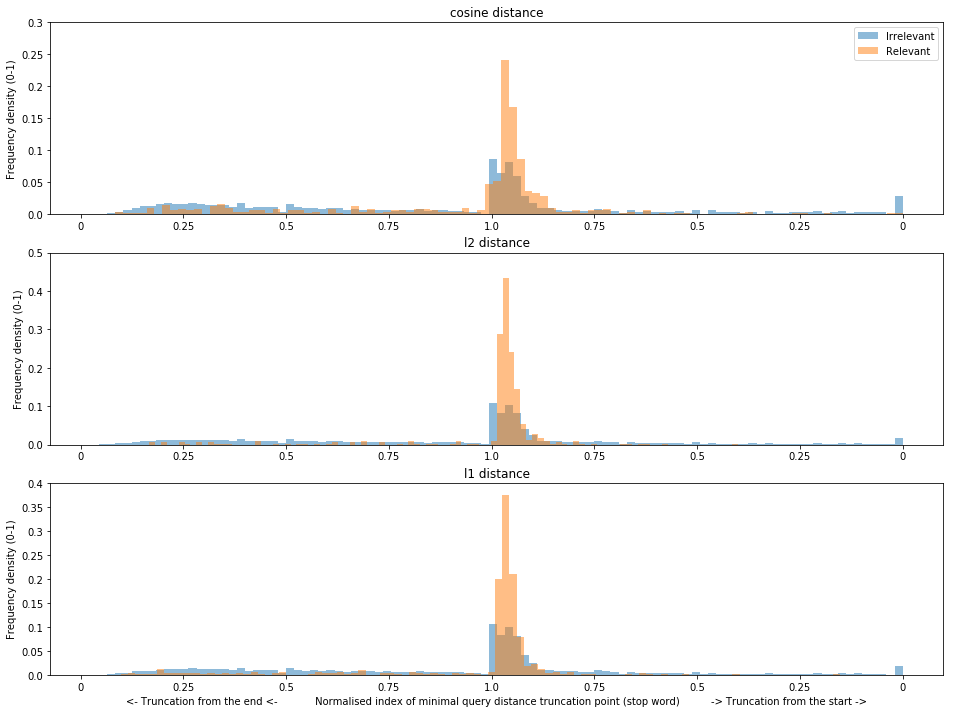

In [142]:
fig = plt.gcf()
fig.set_size_inches((16, 12))
for i in range(len(dist_funcs)):
    g = fig.add_subplot(len(dist_funcs), 1, i + 1)
    plt.title(dist_funcs[i][0].__name__)
    idx_loc = []
    nel_idx = np.nonzero(np.asarray(Y) == 0)[0]
    i_ = -1
    for (n_words, idx) in idx_freqs[i]:
        i_ += 1
        if i_ in nel_idx:
            idx_loc.append(idx / max(n_words - 1, 1))
    g.hist((np.round(np.asarray(idx_loc), 4) * 10000).astype(int), bins=100, density=True, alpha=0.5, label="Irrelevant")
    idx_loc = []
    rel_idx = np.nonzero(np.asarray(Y) == 1)[0]
    i_ = -1
    for (n_words, idx) in idx_freqs[i]:
        i_ += 1
        if i_ in rel_idx:
            idx_loc.append(idx / max(n_words - 1, 1))
    g.hist((np.round(np.asarray(idx_loc), 4) * 10000).astype(int), bins=100, density=True, alpha=0.5, label="Relevant")
    plt.ylabel("Frequency density (0-1)")
    yls = [float(str(val)) for val in list(plt.yticks())[0]]
    plt.yticks(yls, [str(round(val * 100, 10)) for val in yls])
    xls = np.asarray([0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0]) / 2
    xlabels = [0, 0.25, 0.5, 0.75, 1.0, 0.75, 0.5, 0.25, 0]
    plt.xticks(xls * 10000, [str(x) for x in xlabels])
    if i == 0:
        plt.legend()
plt.xlabel("<- Truncation from the end <- " + \
           "           Normalised index of minimal query distance truncation point (stop word)          " + \
           "-> Truncation from the start ->")
plt.show()

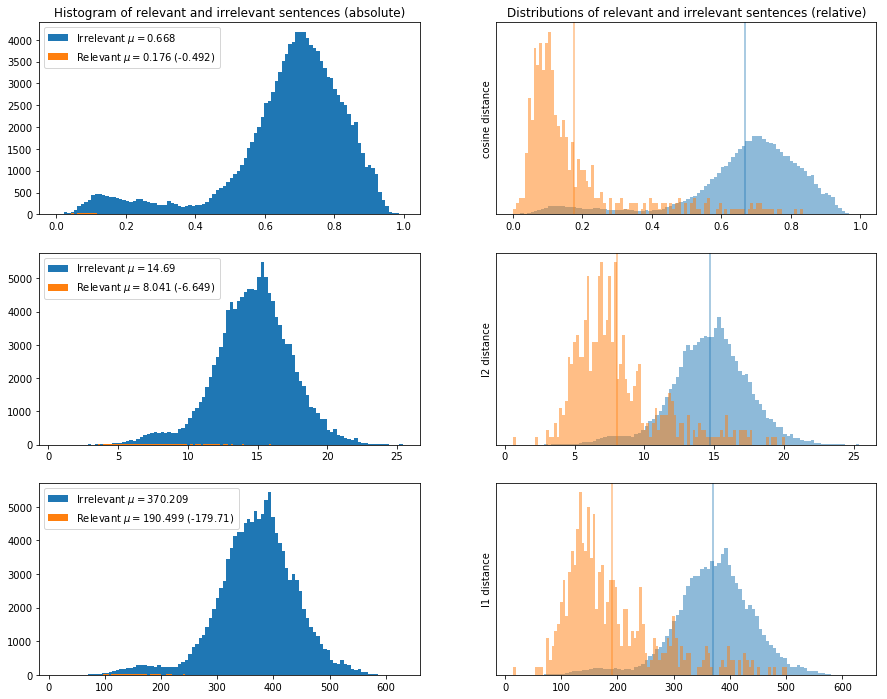

In [239]:
fig = plt.figure()
fig.set_size_inches(15, 12)
for k in range(1, len(dist_funcs) + 1):
    fig.add_subplot(len(dist_funcs), 2, (k * 2) - 1)
    res_nel = res_dists[k - 1][np.nonzero(np.asarray(Y) == 0)[0]]
    plt.hist(res_dists[k - 1], bins=100, label="Irrelevant $\mu = $" + str(round(np.mean(res_nel), 3)))
    res_rel = res_dists[k - 1][np.nonzero(np.asarray(Y) == 1)[0]]
    plt.hist(res_rel, bins=100, label="Relevant $\mu = $" + str(round(np.mean(res_rel), 3)) + \
             " (" + str(round(np.mean(res_rel) - np.mean(res_nel), 3)) + ")")
    if k == 1:
        plt.title("Histogram of relevant and irrelevant sentences (absolute)")
    plt.legend(loc="upper left")
    fig.add_subplot(len(dist_funcs), 2, k * 2)
    _, _, p = plt.hist(res_dists[k - 1], density=True, bins=100, alpha=0.5)
    plt.axvline(x=np.mean(res_nel), color=p[0].get_facecolor())
    res_rel = res_dists[k - 1][np.nonzero(np.asarray(Y) == 1)[0]]
    _, _, p = plt.hist(res_rel, density=True, bins=100, alpha=0.5)
    plt.axvline(x=np.mean(res_rel), color=p[0].get_facecolor())
    if k == 1:
        plt.title("Distributions of relevant and irrelevant sentences (relative)")
    plt.ylabel(dist_funcs[k - 1][0].__name__)
    plt.yticks([])
plt.show()

In [ ]:
# We learn a classifier that predicts the 0.4% of sentences retrieved which are relevant, though this a one-dimensional
# approximation to identifying them, because many have no direct relation with the query string by themself; though
# they may have a relation with the query string when taken in addition to (one of) the other relevant sentences. Ie.,
# "Chad is a country in Africa" seems irrelevant to the query "Ryan Gosling has been to a country in Africa" except when we
# we include the other query-relevant sentence in the phrase: "Ryan Gosling has been to Chad. Chad is a country in Africa.").

In [ ]:
# Theoretically, we could consider every possible pair of sentences in the retrieved documents and compare distances to these
# 'dual' evidences, however, we have no way of knowing whether we know the correct number of sentences (2), even if we simply
# choose the combination and length that minimises the distance to the query. For a retrived sentence list of length 50, there
# are 2450 unique permutations of pairs of sentences. The question becomes, whether we can achieve a higher relevance
# classification accuracy for the individual sentences by pairing them up and looking for higher relevance pairs than
# the original sentences were individually. The final classification would then be performed by thresholding the decision
# function and taking all unique sentences from the set of sentences and sentence pairs which fall above the threshold. This
# may be unlikely to improve accuracy, however, because most of the evidences are single sentences, and when pairing sentences
# exhaustively for a 50-fold increase in set size, there are likely to be pairs which spontaneously have lower distance
# to the query despite not having any real similarity, the classification being erroneous. The tradeoff between potential
# increase in accuracy on dual evidences etc may not be not be enough to overcome the loss in accuracy on singular evidences.

In [ ]:
# In addition, due to the difference between predicting the next word in a sentence (language modelling minimising perplexity),
# and predicting whether one sentence is relevant to a given fact checking query, a nonlinear model that can capture interactions
# between different dimensions of the sentence embedding (such as logical relationships between entities) may prove beneficial.
# Since our training data assumes that relevance is relative ("Chad is a country in Africa" is relevant, while "Uganda is
# a country in Africa" is not; relevance is relative to the other evidence sentence), a more complex algorithm that makes use
# of the logical deduction heuristic present in the fact checking task may also prove highly effective. For example, 
# hybrid abductive inductive learning, combined with common knowledge bases, graphs and ontologies, such as BabelNet and Cyc.
# The logic-based heuristic may also be automatically learned through (attention-utilising) data driven models, at the expense
# of a certain amount of interpretability and possibly some errors in previously well-classified areas of the sample
# distribution. A more refined version could perform the final decidability check based on the candidate relevant sentences 
# and deduce whether a fact is true or not.

In [636]:
Y = np.asarray(Y).astype(int)
Y.shape, res.shape, res_dists.shape, 100 * sum(Y)/len(Y)

((125221,), (3, 125221, 1024), (3, 125221), 0.40328698860414786)

In [637]:
# Shuffle data, stratifying the relevant samples (minority class) so that we can easily split & evaluate fairly later
nel_idx = np.nonzero(Y == 0)[0]
rel_idx = np.nonzero(Y == 1)[0]
np.random.shuffle(nel_idx)
np.random.shuffle(rel_idx)
shuf_idx, rel_ratio = [], len(nel_idx) // len(rel_idx)
i = -1
for i in range(len(rel_idx)):
    shuf_idx += [nel_idx[i * rel_ratio:(i + 1) * rel_ratio], rel_idx[i:i + 1]]
shuf_idx.append(nel_idx[(i + 1) * rel_ratio:])
print(rel_ratio, "irrelevant samples for every 1 relevant, the last", len(nel_idx[(i + 1) * rel_ratio:]), "are irrelevant")
shuf_idx = np.hstack(shuf_idx)[:125000]  # Use a round number
res = res[:, shuf_idx]
res_dists = res_dists[:, shuf_idx]
Y = Y[shuf_idx]
all_relsamples = [all_relsamples[i] for i in shuf_idx]
idx_freqs = [[ifr[i] for i in shuf_idx] for ifr in idx_freqs]
Y.shape, res.shape, res_dists.shape, 100 * sum(Y)/len(Y)

246 irrelevant samples for every 1 relevant, the last 486 are irrelevant


((125000,), (3, 125000, 1024), (3, 125000), 0.404)

In [638]:
# Split into training & test set (a validation set will be taken from the training set later) (train:val:test = 76:12:12)
n_train = 100000
n_test = 15000
N_df = len(dist_funcs)
dfr = range(N_df)
X_train = [deepcopy(res[k][:n_train]) for k in dfr]
X_test = [deepcopy(res[k][-n_test:]) for k in dfr]
Xd_train = [np.atleast_2d(deepcopy(res_dists[k][:n_train])).T for k in dfr]
Xd_test = [np.atleast_2d(deepcopy(res_dists[k][-n_test:])).T for k in dfr]
Y_train = deepcopy(Y[:n_train])
Y_test = deepcopy(Y[-n_test:])

In [639]:
# Examine the various ways of seperating the two peaks using a 1D threshold
# First, find the threshold values that directly maximises various classification scores (including the negative logistic loss)

In [640]:
from Models import *

In [641]:
def f3_score(y, y_hat):
    return f_beta(y, y_hat, 4)
def f64_score(y, y_hat):
    return f_beta(y, y_hat, 25)

Evaluations: 24/24     

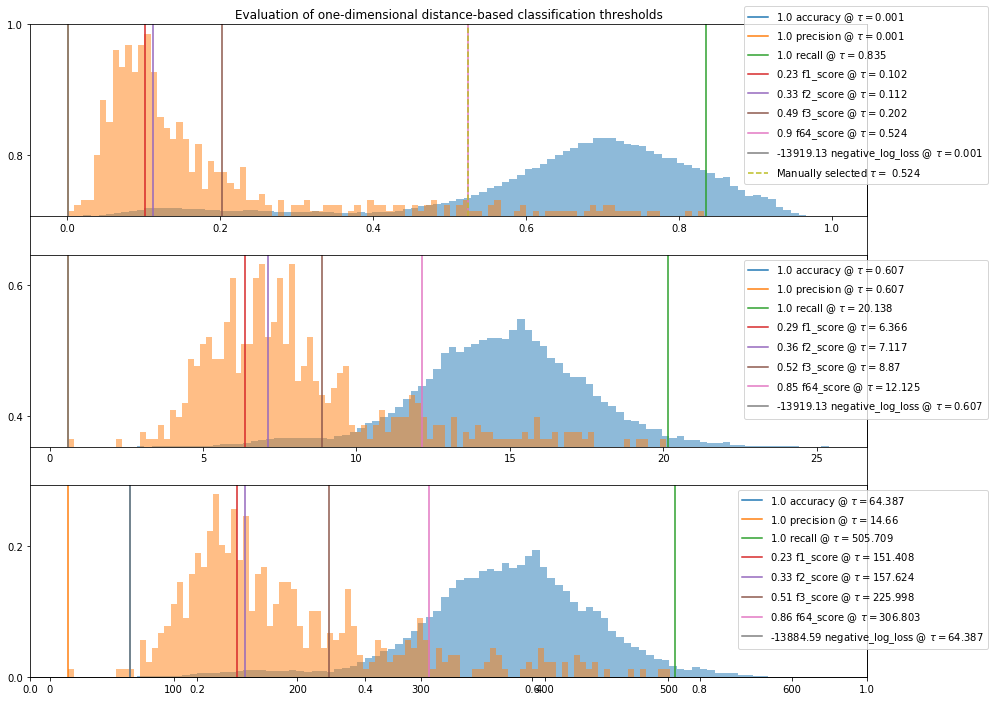

In [644]:
oneD_sfuncs = [accuracy, precision, recall, f1_score, negative_log_loss]
oneD_scores = [[[] for _ in dfr] for _ in range(len(oneD_sfuncs))]
oneD_thresh_res = []
tcount, count = N_df * len(oneD_sfuncs), 0
for k in dfr:
    min_, max_ = np.min(Xd_train[k]), np.max(Xd_train[k])
    thresh_vals = np.linspace(min_ + 1e-4, max_ - 1e-4, 100)
    for t in thresh_vals:
        preds = (Xd_train[k] < t).astype(int).flatten()
        for j in range(len(oneD_sfuncs)):
            oneD_scores[j][k].append(oneD_sfuncs[j](Y_train, preds))
    argmaxs = {}
    for j in range(len(oneD_sfuncs)):
        argmax_i = np.argmax(oneD_scores[j][k])
        argmaxs[oneD_sfuncs[j].__name__] = argmax_i, thresh_vals[argmax_i], oneD_scores[j][k][argmax_i]
        count += 1
        sys_print("\rEvaluations: " + str(count) + '/' + str(tcount) + '     ')
    oneD_thresh_res.append(argmaxs)
tau, tau_dfunc = 0.524, 0  # Manually selected threshold of 0.27 in cosine distance (distance function with index 0)
fig = plt.figure()
fig.set_size_inches(15, 12)
colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.title("Evaluation of one-dimensional distance-based classification thresholds")
for k in dfr:
    fig.add_subplot(N_df, 1, k + 1)
    res_nel = res_dists[k][np.nonzero(Y == 0)[0]]
    plt.hist(res_dists[k], bins=100, density=True, alpha=0.5)
    res_rel = res_dists[k][np.nonzero(Y == 1)[0]]
    plt.hist(res_rel, bins=100, density=True, alpha=0.5)
    j = -1
    for j in range(len(oneD_sfuncs)):
        name = oneD_sfuncs[j].__name__
        r = oneD_thresh_res[k][name]
        plt.axvline(x=r[1], label=str(round(r[2], 2)) + ' ' + name + ' @ $\\tau =$' + str(round(r[1], 3)),
                    color=colours[j])
    if k == 0:
        plt.axvline(x=tau, ls='--', label="Manually selected $\\tau =$ " + str(tau),
                    color=colours[j + 1])
    plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1.12 if k==0 else 1))
    plt.yticks([])
plt.show()

In [592]:
# The above analysis shows that the heavy class imbalance causes most of these methods to fail, including the logistic
# regression. We therefore manually select a thresholding distance metric and distance (of 0.25 in cosine distance), and consider
# points which fall above this threshold as non-relevant (these would likely be misclassified by a full-dataset model)

In [593]:
# First we assess the performance of the model without this preliminary one-dimensional thresholding, uniformly sampling
# the majority class, with an optimal ratio of relevant to non-relevant samples

In [645]:
from sklearn.pipeline import *
from sklearn.preprocessing import *
from sklearn.decomposition import *

In [646]:
n_val = 15000
# n_val = round((12/76) * len(Y_train))  # Use the same ratio as for the test set (76:12:12)
n_trtr = len(Y_train) - n_val
X_trtr = [X_tr[:n_trtr] for X_tr in X_train]
X_val = [X_tr[-n_val:] for X_tr in X_train]
Xd_trtr = [Xd_tr[:n_trtr] for Xd_tr in Xd_train]
Xd_val = [Xd_tr[-n_val:] for Xd_tr in Xd_train]
Y_trtr = Y_train[:n_trtr]
Y_val = Y_train[-n_val:]
12/76, sum(Y_val) / len(Y_val), sum(Y_trtr) / len(Y_trtr)

(0.15789473684210525, 0.004, 0.004047058823529411)

In [695]:
nel_idx = np.nonzero(Y_trtr == 0)[0]
rel_idx = np.nonzero(Y_trtr == 1)[0]
undersampling_ratio = 1.15
n_maj = round(len(rel_idx) * undersampling_ratio)
train_idx = np.hstack([nel_idx[:n_maj], rel_idx])
Xb_train = [X_tr[train_idx] for X_tr in X_trtr]
Xbd_train = [Xd_tr[train_idx] for Xd_tr in Xd_trtr]
Yb_train = Y_trtr[train_idx]

In [696]:
m = LogisticRegression(solver="liblinear")
scores = []
for k in dfr:
    m.fit(Xbd_train[k], Yb_train)
    preds = m.predict(Xd_val[k])
    preds_test = m.predict(Xd_test[k])
#     preds_test = np.logical_and(preds_test, Xd_test[tau_dfunc].flatten() < tau).astype(int)
    scores.append([(sfunc.__name__, sfunc(Y_val, preds), sfunc(Y_test, preds_test)) for sfunc in oneD_sfuncs])
scores

[[('accuracy', 0.9202, 0.9222666666666667),
  ('precision', 0.043373493975903614, 0.042218543046357616),
  ('recall', 0.9, 0.85),
  ('f1_score', 0.08275862068965517, 0.0804416403785489),
  ('f2_score', 0.18181818181818182, 0.1761049723756906),
  ('f3_score', 0.4163265306122449, 0.3999077490774908),
  ('f64_score', 0.8724738675958188, 0.824790740932107),
  ('negative_log_loss', -41342.91534470809, -40272.21327646586)],
 [('accuracy', 0.9187333333333333, 0.9205333333333333),
  ('precision', 0.03898170246618934, 0.03833605220228385),
  ('recall', 0.8166666666666667, 0.7833333333333333),
  ('f1_score', 0.07441154138192863, 0.07309486780715398),
  ('f2_score', 0.16366065464261856, 0.16030013642564805),
  ('f3_score', 0.3757329724853406, 0.3655077767612077),
  ('f64_score', 0.7914441262223598, 0.7597479729380778),
  ('negative_log_loss', -42102.76842539612, -41170.221462733534)],
 [('accuracy', 0.9272, 0.9286),
  ('precision', 0.04336283185840708, 0.04253393665158371),
  ('recall', 0.8166666

In [697]:
m = Pipeline(steps=[
    ("pca", PCA(n_components=150)),
    ("model", LogisticRegression(solver="liblinear"))
])
scores = []
for k in dfr:
    m.fit(Xb_train[k], Yb_train)
    preds = m.predict(X_val[k])
    preds_test = m.predict(X_test[k])
#     preds_test = np.logical_and(preds_test, Xd_test[tau_dfunc].flatten() < tau).astype(int)
    scores.append([(sfunc.__name__, sfunc(Y_val, preds), sfunc(Y_test, preds_test)) for sfunc in oneD_sfuncs])
scores

C:\Users\alfew\Code\IR\facts\Models.py:20: RuntimeWarning: invalid value encountered in long_scalars
  return np.sum(np.logical_and(y, y_hat)) / np.sum(y_hat)
C:\Users\alfew\Code\IR\facts\Models4.py:20: RuntimeWarning: invalid value encountered in long_scalars
  return np.sum(np.logical_and(y, y_hat)) / np.sum(y_hat)
C:\Users\alfew\Code\IR\facts\Models4.py:24: RuntimeWarning: divide by zero encountered in double_scalars
  return 2 / ((1 / precision(y, y_hat)) + (1 / recall(y, y_hat)))


[[('accuracy', 0.996, 0.996),
  ('precision', nan, nan),
  ('recall', 0.0, 0.0),
  ('f1_score', nan, nan),
  ('f2_score', nan, nan),
  ('f3_score', nan, nan),
  ('f64_score', nan, nan),
  ('negative_log_loss', -2072.326583694641, -2072.326583694641)],
 [('accuracy', 0.9118666666666667, 0.9146),
  ('precision', 0.03874269005847953, 0.03785011355034065),
  ('recall', 0.8833333333333333, 0.8333333333333334),
  ('f1_score', 0.0742296918767507, 0.07241129616220131),
  ('f2_score', 0.1648009950248756, 0.16015374759769377),
  ('f3_score', 0.38702749140893467, 0.37264357737834286),
  ('f64_score', 0.8536070803746012, 0.8062646505757194),
  ('negative_log_loss', -45660.26239407192, -44244.17256188059)],
 [('accuracy', 0.9208666666666666, 0.9234666666666667),
  ('precision', 0.0437246963562753, 0.04054054054054054),
  ('recall', 0.9, 0.8),
  ('f1_score', 0.0833976833976834, 0.07717041800643087),
  ('f2_score', 0.1830508474576271, 0.16853932584269662),
  ('f3_score', 0.4182232346241458, 0.3805970

In [716]:
m = Pipeline(steps=[
#     ("pca", PCA(n_components=150)),
    ("model", LogisticRegression(solver="liblinear"))
])
scores = []
for k in dfr:
    m.fit(np.hstack([Xb_train[k], Xbd_train[k]]), Yb_train)
    preds = m.predict(np.hstack([X_val[k], Xd_val[k]]))
    preds_test = m.predict(np.hstack([X_test[k], Xd_test[k]]))
#     preds_test = np.logical_and(preds_test, Xd_test[tau_dfunc].flatten() < tau).astype(int)
    scores.append([(sfunc.__name__, sfunc(Y_val, preds), sfunc(Y_test, preds_test)) for sfunc in oneD_sfuncs])
scores

[[('accuracy', 0.9201333333333334, 0.922),
  ('precision', 0.04333868378812199, 0.04207920792079208),
  ('recall', 0.9, 0.85),
  ('f1_score', 0.08269525267993874, 0.08018867924528303),
  ('f2_score', 0.1816958277254374, 0.17561983471074383),
  ('f3_score', 0.41613780598368083, 0.39917127071823205),
  ('f64_score', 0.8724513498167553, 0.8247055176689398),
  ('negative_log_loss', -41377.454121103, -40410.368382045504)],
 [('accuracy', 0.9, 0.9044666666666666),
  ('precision', 0.03608247422680412, 0.03457627118644068),
  ('recall', 0.9333333333333333, 0.85),
  ('f1_score', 0.0694789081885856, 0.06644951140065147),
  ('f2_score', 0.15625, 0.14868804664723034),
  ('f3_score', 0.3789808917197452, 0.3560574948665298),
  ('f64_score', 0.8976748950117793, 0.8191404746632457),
  ('negative_log_loss', -51808.164592366025, -49494.06657390701)],
 [('accuracy', 0.892, 0.8948),
  ('precision', 0.03181272509003601, 0.030902348578491966),
  ('recall', 0.8833333333333333, 0.8333333333333334),
  ('f1_sco

In [699]:
m = Pipeline(steps=[
#     ("pca", PCA(n_components=220)),
    ("model", LogisticRegression(solver="liblinear"))
])
scores = []
m.fit(np.hstack(sum([[Xbd_train[k]] for k in dfr], [])), Yb_train)
preds = m.predict(np.hstack(sum([[Xd_val[k]] for k in dfr], [])))
preds_test = m.predict(np.hstack(sum([[Xd_test[k]] for k in dfr], [])))
# preds_test = np.logical_and(preds_test, Xd_test[tau_dfunc].flatten() < tau).astype(int)
scores.append([(sfunc.__name__, sfunc(Y_val, preds), sfunc(Y_test, preds_test)) for sfunc in oneD_sfuncs])
scores

[[('accuracy', 0.9304, 0.9306),
  ('precision', 0.04862385321100918, 0.04541241890639481),
  ('recall', 0.8833333333333333, 0.8166666666666667),
  ('f1_score', 0.09217391304347827, 0.08604038630377525),
  ('f2_score', 0.19924812030075192, 0.18574677786201665),
  ('f3_score', 0.4395121951219512, 0.40853359489946045),
  ('f64_score', 0.8597564135786473, 0.7950957774955286),
  ('negative_log_loss', -36058.48255628675, -35954.86622710202)]]

In [714]:
m = Pipeline(steps=[
#     ("pca", PCA(n_components=220)),
    ("model", LogisticRegression(solver="liblinear"))
])
scores = []
m.fit(np.hstack(sum([[Xb_train[k], Xbd_train[k]] for k in dfr], [])), Yb_train)
preds = m.predict(np.hstack(sum([[X_val[k], Xd_val[k]] for k in dfr], [])))
preds_test = m.predict(np.hstack(sum([[X_test[k], Xd_test[k]] for k in dfr], [])))
# preds_test = np.logical_and(preds_test, Xd_test[tau_dfunc].flatten() < tau).astype(int)
scores.append([(sfunc.__name__, sfunc(Y_val, preds), sfunc(Y_test, preds_test)) for sfunc in oneD_sfuncs])
scores

[[('accuracy', 0.8962666666666667, 0.9031333333333333),
  ('precision', 0.03482587064676617, 0.03473613894455578),
  ('recall', 0.9333333333333333, 0.8666666666666667),
  ('f1_score', 0.0671462829736211, 0.06679511881824021),
  ('f2_score', 0.15151515151515152, 0.1496833621185953),
  ('f3_score', 0.37071651090342683, 0.35978835978835977),
  ('f64_score', 0.896389485527258, 0.8347308767341077),
  ('negative_log_loss', -53742.33607048102, -50184.84210180522)]]

In [701]:
# Now, take only the training samples which fall below the threshold
refined_idx = np.nonzero(Xd_train[tau_dfunc] < tau)[0]
Xr_train = [X_tr[refined_idx] for X_tr in X_train]
Xrd_train = [Xd_tr[refined_idx] for Xd_tr in Xd_train]
Yr_train = Y_train[refined_idx]
refined_idx.shape[0], refined_idx.shape[0] / n_train, sum(Yr_train), sum(Yr_train) / len(Yr_train)

(13645, 0.13645, 381, 0.02792231586661781)

In [654]:
# Class imbalance has been reduced by a factor of approximately 17, however, we still have heavy imbalance of ratio 94:6.
# To create a useful balanced dataset, we uniformly undersample the majority class,
# increasing the number until we achieve peak performance in the resulting model evaluated by f1 score on a validation set

In [655]:
n_val = round((12/76) * len(Yr_train))  # Use the same ratio as for the test set (76:12:12)
n_trtr = len(Yr_train) - n_val
Xr_trtr = [Xr_tr[:n_trtr] for Xr_tr in Xr_train]
Xr_val = [Xr_tr[-n_val:] for Xr_tr in Xr_train]
Xrd_trtr = [Xrd_tr[:n_trtr] for Xrd_tr in Xrd_train]
Xrd_val = [Xrd_tr[-n_val:] for Xrd_tr in Xrd_train]
Yr_trtr = Yr_train[:n_trtr]
Yr_val = Yr_train[-n_val:]
12/76, sum(Yr_val) / len(Yr_val), sum(Yr_trtr) / len(Yr_trtr)

(0.15789473684210525, 0.027855153203342618, 0.027934905578278654)

In [656]:
nel_idx = np.nonzero(Yr_trtr == 0)[0]
rel_idx = np.nonzero(Yr_trtr == 1)[0]
undersampling_ratio = 1.05
n_maj = round(len(rel_idx) * undersampling_ratio)
train_idx = np.hstack([nel_idx[:n_maj], rel_idx])
Xb_train = [Xr_tr[train_idx] for Xr_tr in Xr_trtr]
Xbd_train = [Xrd_tr[train_idx] for Xrd_tr in Xrd_trtr]
Yb_train = Yr_trtr[train_idx]

In [657]:
# Order irrelevant samples by their Euclidean distance to the nearest relevant sample, and the mean of relevant samples,
# and try undersampling the majority class using the closest samples first (compare both methods)

In [658]:
m = LogisticRegression(solver="liblinear")
scores = []
for k in dfr:
    m.fit(Xbd_train[k], Yb_train)
    preds = m.predict(Xrd_val[k])
    preds_test = m.predict(Xd_test[k])
    preds_test = np.logical_and(preds_test, Xd_test[tau_dfunc].flatten() < tau).astype(int)
    scores.append([(sfunc.__name__, sfunc(Yr_val, preds), sfunc(Y_test, preds_test)) for sfunc in oneD_sfuncs])
scores

[[('accuracy', 0.6824512534818942, 0.9565333333333333),
  ('precision', 0.06786703601108034, 0.06598240469208211),
  ('recall', 0.8166666666666667, 0.75),
  ('f1_score', 0.12531969309462915, 0.12129380053908355),
  ('f2_score', 0.2546777546777547, 0.2440347071583514),
  ('f3_score', 0.49524375743162896, 0.4658952496954933),
  ('f64_score', 0.8025221076866725, 0.737782201037138),
  ('negative_log_loss', -23624.52305411891, -22519.282209481767)],
 [('accuracy', 0.7711234911792015, 0.9686),
  ('precision', 0.08445297504798464, 0.08982035928143713),
  ('recall', 0.7333333333333333, 0.75),
  ('f1_score', 0.1514629948364888, 0.16042780748663102),
  ('f2_score', 0.2890932982917214, 0.30364372469635625),
  ('f3_score', 0.5050641458474003, 0.5236139630390144),
  ('f64_score', 0.7244417558717551, 0.741296281676798),
  ('negative_log_loss', -17027.616762690966, -16267.763682002931)],
 [('accuracy', 0.7688022284122563, 0.9687333333333333),
  ('precision', 0.08365019011406843, 0.08853118712273642),

In [659]:
m = Pipeline(steps=[
    ("pca", PCA(n_components=150)),
    ("model", LogisticRegression(solver="liblinear"))
])
scores = []
for k in dfr:
    m.fit(Xb_train[k], Yb_train)
    preds = m.predict(Xr_val[k])
    preds_test = m.predict(X_test[k])
    preds_test = np.logical_and(preds_test, Xd_test[tau_dfunc].flatten() < tau).astype(int)
    scores.append([(sfunc.__name__, sfunc(Yr_val, preds), sfunc(Y_test, preds_test)) for sfunc in oneD_sfuncs])
scores

C:\Users\alfew\Code\IR\facts\Models.py:20: RuntimeWarning: invalid value encountered in long_scalars
  return np.sum(np.logical_and(y, y_hat)) / np.sum(y_hat)
C:\Users\alfew\Code\IR\facts\Models4.py:20: RuntimeWarning: invalid value encountered in long_scalars
  return np.sum(np.logical_and(y, y_hat)) / np.sum(y_hat)
C:\Users\alfew\Code\IR\facts\Models4.py:24: RuntimeWarning: divide by zero encountered in double_scalars
  return 2 / ((1 / precision(y, y_hat)) + (1 / recall(y, y_hat)))


[[('accuracy', 0.9721448467966574, 0.996),
  ('precision', nan, nan),
  ('recall', 0.0, 0.0),
  ('f1_score', nan, nan),
  ('f2_score', nan, nan),
  ('f3_score', nan, nan),
  ('f64_score', nan, nan),
  ('negative_log_loss', -2072.326583694641, -2072.326583694641)],
 [('accuracy', 0.786908077994429, 0.9716),
  ('precision', 0.09533468559837728, 0.09513274336283185),
  ('recall', 0.7833333333333333, 0.7166666666666667),
  ('f1_score', 0.16998191681735986, 0.16796874999999997),
  ('f2_score', 0.320600272851296, 0.3106936416184971),
  ('f3_score', 0.5498967653131451, 0.5177053824362607),
  ('f64_score', 0.7744058115968732, 0.7092643338954469),
  ('negative_log_loss', -15853.298365264003, -14713.518744231951)],
 [('accuracy', 0.7948003714020427, 0.9743333333333334),
  ('precision', 0.09873949579831932, 0.10268948655256724),
  ('recall', 0.7833333333333333, 0.7),
  ('f1_score', 0.17537313432835822, 0.17910447761194032),
  ('f2_score', 0.32821229050279327, 0.3235747303543914),
  ('f3_score', 0

In [660]:
m = Pipeline(steps=[
    ("pca", PCA(n_components=155)),
    ("model", LogisticRegression(solver="liblinear"))
])
scores = []
for k in dfr:
    m.fit(np.hstack([Xb_train[k], Xbd_train[k]]), Yb_train)
    preds = m.predict(np.hstack([Xr_val[k], Xrd_val[k]]))
    preds_test = m.predict(np.hstack([X_test[k], Xd_test[k]]))
    preds_test = np.logical_and(preds_test, Xd_test[tau_dfunc].flatten() < tau).astype(int)
    scores.append([(sfunc.__name__, sfunc(Yr_val, preds), sfunc(Y_test, preds_test)) for sfunc in oneD_sfuncs])
scores

[[('accuracy', 0.680594243268338, 0.9560666666666666),
  ('precision', 0.0674931129476584, 0.06531204644412192),
  ('recall', 0.8166666666666667, 0.75),
  ('f1_score', 0.1246819338422392, 0.12016021361815755),
  ('f2_score', 0.2536231884057971, 0.24219590958019377),
  ('f3_score', 0.49406880189798336, 0.4639175257731959),
  ('f64_score', 0.8024381311149479, 0.7376469664039382),
  ('negative_log_loss', -23762.678159698553, -22761.053644246138)],
 [('accuracy', 0.8003714020427113, 0.9735333333333334),
  ('precision', 0.09782608695652174, 0.0997624703087886),
  ('recall', 0.75, 0.7),
  ('f1_score', 0.17307692307692307, 0.17463617463617465),
  ('f2_score', 0.32142857142857145, 0.3177004538577912),
  ('f3_score', 0.5387323943661972, 0.5170166545981172),
  ('f64_score', 0.7420969441517385, 0.6933361461986761),
  ('negative_log_loss', -14851.673849811592, -13711.89422877954)],
 [('accuracy', 0.8073351903435468, 0.9754),
  ('precision', 0.1029082774049217, 0.10077519379844961),
  ('recall', 0.

In [661]:
m = Pipeline(steps=[
#     ("pca", PCA(n_components=220)),
    ("model", LogisticRegression(solver="liblinear"))
])
scores = []
m.fit(np.hstack(sum([[Xbd_train[k]] for k in dfr], [])), Yb_train)
preds = m.predict(np.hstack(sum([[Xd_val[k]] for k in dfr], [])))
preds_test = m.predict(np.hstack(sum([[Xd_test[k]] for k in dfr], [])))
preds_test = np.logical_and(preds_test, Xd_test[tau_dfunc].flatten() < tau).astype(int)
scores.append([(sfunc.__name__, sfunc(Y_val, preds), sfunc(Y_test, preds_test)) for sfunc in oneD_sfuncs])
scores

[[('accuracy', 0.9674666666666667, 0.9679333333333333),
  ('precision', 0.08203125, 0.08806262230919765),
  ('recall', 0.7, 0.75),
  ('f1_score', 0.14685314685314685, 0.15761821366024517),
  ('f2_score', 0.2792553191489362, 0.2996005326231691),
  ('f3_score', 0.48505434782608686, 0.5200543847722637),
  ('f64_score', 0.6916763127433441, 0.7411012601615321),
  ('negative_log_loss', -16854.92288071641, -16613.15144595204)]]

In [667]:
m = Pipeline(steps=[
    ("pca", PCA(n_components=200)),
    ("model", LogisticRegression(solver="liblinear"))
])
scores = []
m.fit(np.hstack(sum([[Xb_train[k], Xbd_train[k]] for k in dfr], [])), Yb_train)
preds = m.predict(np.hstack(sum([[X_val[k], Xd_val[k]] for k in dfr], [])))
preds_test = m.predict(np.hstack(sum([[X_test[k], Xd_test[k]] for k in dfr], [])))
preds_test = np.logical_and(preds_test, Xd_test[tau_dfunc].flatten() < tau).astype(int)
scores.append([(sfunc.__name__, sfunc(Y_val, preds), sfunc(Y_test, preds_test)) for sfunc in oneD_sfuncs])
scores

[[('accuracy', 0.9685333333333334, 0.9750666666666666),
  ('precision', 0.08964143426294821, 0.09743589743589744),
  ('recall', 0.75, 0.6333333333333333),
  ('f1_score', 0.1601423487544484, 0.16888888888888887),
  ('f2_score', 0.3032345013477089, 0.30158730158730157),
  ('f3_score', 0.5232558139534883, 0.47851851851851845),
  ('f64_score', 0.7412767749065837, 0.6278173660596463),
  ('negative_log_loss', -16302.30245839784, -12917.502371696595)]]

In [609]:
# Standardise the data to zero mean & unit variance
X_center = [np.mean(X_train[k], axis=0) for k in dfr]
X_train = [X_train[k] - X_center[k] for k in dfr]
X_test = [X_test[k] - X_center[k] for k in dfr]
X_scale = np.std(X_train, axis=0)
X_train /= X_scale
X_test /= X_scale
X_center, X_scale, np.mean(X_train, axis=0), np.std(X_train, axis=0), X_center.shape

ValueError: operands could not be broadcast together with shapes (3,15000,1024) (100000,1024) 

In [147]:
Xd_center = np.mean(Xd_train, axis=0)
Xd_train -= Xd_center
Xd_test -= Xd_center
Xd_scale = np.std(Xd_train, axis=0)
Xd_train /= Xd_scale
Xd_test /= Xd_scale
Xd_center, Xd_scale, np.mean(Xd_train, axis=0), np.std(Xd_train, axis=0), Xd_center.shape

(array([0.66778728]),
 array([0.17532205]),
 array([1.59730007e-16]),
 array([1.]),
 (1,))

In [24]:
i = np.nonzero(np.asarray(Y) == 1)[0][17]
# i = 455
idx_freqs[0][i], all_relsamples[i], res_dists[0, i], rel_data[all_relsamples[i][-2]]

NameError: name 'idx_freqs' is not defined

In [ ]:
# Try to seperate samples by the similarity measure alone (a 1D logistic regression)

In [66]:
m = LR(eta=1e-8, tol=1e-10, no_imp_stop=50000, w_init='uniform', print_steps=100)
m.fit(X_train, Y_train)

|  iteration  |   loss   |  accuracy   |   precision   |   recall   |   f1_score   |   f2_score   |
|  0  |  3453877.7064911867  |  0.49775  |  0.0018198  |  0.2269327  |  0.0036106  |  0.0088161  |
|  100  |  3453877.70560409  |  0.58325  |  0.0037035  |  0.3840399  |  0.0073363  |  0.0178299  |
|  200  |  3453877.707375094  |  0.65298  |  0.0052503  |  0.4538653  |  0.0103804  |  0.0250903  |
|  300  |  3453877.7114273575  |  0.71343  |  0.0062212  |  0.4438903  |  0.0122704  |  0.0294546  |
|  400  |  3453877.717562127  |  0.76658  |  0.007048  |  0.4089776  |  0.0138572  |  0.0329675  |
|  500  |  3453877.725611961  |  0.81426  |  0.0085456  |  0.394015  |  0.0167284  |  0.0393172  |
|  600  |  3453877.7354239533  |  0.85535  |  0.0098285  |  0.3516209  |  0.0191225  |  0.0442006  |
|  700  |  3453877.7468571234  |  0.89019  |  0.011542  |  0.3117207  |  0.0222598  |  0.0502654  |
|  800  |  3453877.75978122  |  0.91845  |  0.0133066  |  0.2643392  |  0.0253376  |  0.0553814  |
|  

C:\Users\alfew\Code\IR\facts\Models4.py:20: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(np.logical_and(y, y_hat)) / np.sum(y_hat)
C:\Users\alfew\Code\IR\facts\Models4.py:24: RuntimeWarning: divide by zero encountered in double_scalars
  return 2 / ((1 / precision(y, y_hat)) + (1 / recall(y, y_hat)))


|  2700  |  3453878.1704102377  |  0.99599  |  nan  |  0.0  |  nan  |  nan  |
|  2800  |  3453878.1965572303  |  0.99599  |  nan  |  0.0  |  nan  |  nan  |
|  2900  |  3453878.2228890625  |  0.99599  |  nan  |  0.0  |  nan  |  nan  |
|  3000  |  3453878.249381916  |  0.99599  |  nan  |  0.0  |  nan  |  nan  |


KeyboardInterrupt: 

In [ ]:
# Draw learning curve (accuracy vs number of training datapoints)


In [71]:
sum(res[0, 0] == 0) / res.shape[2]
# pr((res[0, 1] * 100).astype(int).tolist())

1.0

In [47]:
res[0, 0]

array([ 2.60268367e-04, -2.50943645e-04,  3.05683934e-04, ...,
       -4.38701645e-05, -2.49852281e-04,  1.84566437e-04])

In [43]:
sum(res[0, 2])

0.0

In [36]:
len(all_relsamples), len(Y)

(165675, 165675)

In [113]:
elmo_samples.shape

(128, 180, 1024)

In [215]:
nlp = spacy.load('en', disable=['tagger', 'parser', 'ner', 'entity_linker', 'textcat', 'entity_ruler', 'sentencizer'])
for token in nlp("what the heck is that apples"):
    print(token.lemma_, type(token.lemma_))

what <class 'str'>
the <class 'str'>
heck <class 'str'>
be <class 'str'>
that <class 'str'>
apple <class 'str'>


In [211]:
nlp = spacy.load('en')
nlp("what the heck is that hippos")

what the heck is that hippos

In [91]:
x = np.asarray([[2,4],[-3,4],[5,3]])
y = np.array([1,2])
# np.sum(x * y, axis=1) / np.atleast_2d((np.sqrt(np.sum(x ** 2, axis=1)) * np.sqrt(np.sum(y ** 2))))
np.sum(x * y / np.atleast_2d((np.sqrt(np.sum(x ** 2, axis=1)) * np.sqrt(np.sum(y ** 2)))).T, axis=1)

array([1.        , 0.4472136 , 0.84366149])

In [37]:
# Figure out how long we should limit sentences to be when extracting embeddings (some outliers with len >1000 exist)
long_rel = 0
for i in range(len(rel_data)):
    for d_t in rel_data[i]["relevance_samples"]:
        for title, line, relevant in rel_data[i]["relevance_samples"][d_t]:
            if relevant and len(line.split(' ')) > 125:
                long_rel += 1
long_rel

0

In [51]:
claims

[{'id': 75397,
  'verifiable': 'VERIFIABLE',
  'label': 'SUPPORTS',
  'claim': 'Nikolaj Coster-Waldau worked with the Fox Broadcasting Company.',
  'evidence': [[[92206, 104971, 'Nikolaj_Coster-Waldau', 7],
    [92206, 104971, 'Fox_Broadcasting_Company', 0]]],
  'vocab': defaultdict(int,
              {'nikolaj': 1,
               'costerwaldau': 1,
               'worked': 1,
               'with': 1,
               'the': 1,
               'fox': 1,
               'broadcasting': 1,
               'company': 1})},
 {'id': 150448,
  'verifiable': 'VERIFIABLE',
  'label': 'SUPPORTS',
  'claim': 'Roman Atwood is a content creator.',
  'evidence': [[[174271, 187498, 'Roman_Atwood', 1]],
   [[174271, 187499, 'Roman_Atwood', 3]]],
  'vocab': defaultdict(int,
              {'roman': 1,
               'atwood': 1,
               'is': 1,
               'a': 1,
               'content': 1,
               'creator': 1})},
 {'id': 214861,
  'verifiable': 'VERIFIABLE',
  'label': 'SUPPORTS',
  '

In [64]:
# Retrieve top-5 similar documents using Laplace smoothing with Lidstone correction (using epsilon=0.05)
res = eval_model(lidstone_ll, epsilon=0.05, claims_=claims)
acc = res[0]
print(acc)
pr(res[1])

Computing similarities...
Batches: 540


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:  6.7min
[Parallel(n_jobs=96)]: Done 258 tasks      | elapsed: 11.6min
[Parallel(n_jobs=96)]: Done 458 out of 540 | elapsed: 17.8min remaining:  3.2min
[Parallel(n_jobs=96)]: Done 540 out of 540 | elapsed: 20.1min finished


Ranking documents...
Evaluating accuracy...
0.25666666666666665
[   [   (-88.32562602513612, 'Glossary_of_sumo_terms'),
        (-87.53034574001876, 'List_of_books_by_Jacob_Neusner'),
        (-87.09446736251365, 'List_of_video_game_crowdfunding_projects'),
        (-85.96664404030582, 'List_of_Latin_legal_terms'),
        (-85.88756594576691, 'List_of_songs_about_Paris')],
    [   (-113.69317923324901, 'Kanye_West_discography'),
        (-113.54722278740641, 'Outkast_discography'),
        (-110.87900565825775, 'Beyoncé_discography'),
        (-108.62218353065947, 'Ricky_Martin_singles_discography'),
        (-102.18636581560878, 'Snoop_Dogg_discography')],
    [   (-69.90791042003866, 'Alma_Ziegler'),
        (-69.85513001771425, 'Timeline_of_San_Bernardino,_California_history'),
        (-69.38033061091798, 'List_of_video_game_crowdfunding_projects'),
        (-68.90621816887726, 'Science_and_technology_in_Venezuela'),
        (-68.33329707121771, 'Wally_Donald')],
    [   (-97.3246

In [65]:
len(res[1])

100

In [132]:
similarities = [jm_ll(*wiki[doc_id]) for doc_id in D_ids]
print("Ranking documents...")
top_docs = []
for i in range(N_claims):
    sims = [(similarities[j][i], D_ids[j]) for j in range(N_docs)]
    sims.sort()
    top_docs.append(sims[-5:])
top_docs_ids = [[s[1] for s in s_] for s_ in top_docs]
print("Evaluating accuracy...")
recall = [np.mean([
    id_ in top_docs_ids[i] for id_ in set([s[2] for s in sum(claims[i]["evidence"], [])])]) \
                  for i in range(len(claims))]
np.mean(recall), top_docs

wat defaultdict(<class 'int'>, {'hunger': 0})


ZeroDivisionError: float division by zero

In [88]:
claims

[{'id': 75397,
  'verifiable': 'VERIFIABLE',
  'label': 'SUPPORTS',
  'claim': 'Nikolaj Coster-Waldau worked with the Fox Broadcasting Company.',
  'evidence': [[[92206, 104971, 'Nikolaj_Coster-Waldau', 7],
    [92206, 104971, 'Fox_Broadcasting_Company', 0]]],
  'vocab': defaultdict(int,
              {'nikolaj': 1,
               'costerwaldau': 1,
               'worked': 1,
               'with': 1,
               'the': 1,
               'fox': 1,
               'broadcasting': 1,
               'company': 1})},
 {'id': 150448,
  'verifiable': 'VERIFIABLE',
  'label': 'SUPPORTS',
  'claim': 'Roman Atwood is a content creator.',
  'evidence': [[[174271, 187498, 'Roman_Atwood', 1]],
   [[174271, 187499, 'Roman_Atwood', 3]]],
  'vocab': defaultdict(int,
              {'roman': 1,
               'atwood': 1,
               'is': 1,
               'a': 1,
               'content': 1,
               'creator': 1})},
 {'id': 214861,
  'verifiable': 'VERIFIABLE',
  'label': 'SUPPORTS',
  '

In [13]:
claim_ids = [75397, 150448, 214861, 156709, 129629, 33078, 6744, 226034, 40190, 76253]
claims = []
claims_vocab = set()
with open(data_dir + "train.jsonl", 'r') as f:
    a = jsonlines.Reader(f)
    for a_ in a:
        if a_["id"] in claim_ids:
            claims.append(a_)
            claims[-1]["vocab"] = defaultdict(int)
            for w in a_["claim"].replace('-LRB-', '').replace('-RRB-', '').replace("'s", ''). \
              translate(punc_trans).lower().split():
                claims[-1]["vocab"][w] += 1
                claims_vocab.add(w)

In [15]:
N_docs = 0
n_t = defaultdict(int)
i_ = 0
for fn in fs:
    with open(fn, 'r') as f:
        a = jsonlines.Reader(f)
        for a_ in a:
            if a_["id"] == "":
                continue
            N_docs += 1
            entry = [[w.translate(punc_trans).lower() for w in l.split()[1:] if w != \
                     '' and not ((any(c.isnumeric() for c in w) and len(w) > 7) or \
                                 (w.isnumeric() and len(w) > 5))] for l in a_[
                    "lines"].replace('-LRB-', '').replace('-RRB-', '').replace("'s", '').split('\n') if \
                     len(l) > 0 and not (len(l) == 1 and l[0].isnumeric())]
            for w in set(sum(entry, [])):
                if w in claims_vocab:
                    n_t[w] += 1
    i_ += 1
    sys_print("\r" + str(i_))
N_docs

109

5416536

In [19]:
# Load each document and measure cosine similarity
similarities = {}
i_ = 0
for fn in fs:
    with open(fn, 'r') as f:
        a = jsonlines.Reader(f)
        for a_ in a:
            if a_["id"] == "":
                continue
            doc_tf = defaultdict(int)
            for l in ([w.translate(punc_trans).lower() for w in l.split()[1:] if w != \
                     '' and not ((any(c.isnumeric() for c in w) and len(w) > 7) or \
                                 (w.isnumeric() and len(w) > 5))] for l in a_[
                    "lines"].replace('-LRB-', '').replace('-RRB-', '').replace("'s", '').split('\n') if \
                     len(l) > 0 and not (len(l) == 1 and l[0].isnumeric())):
                for w in l:
                    if w in claims_vocab:
                        doc_tf[w] += 1
            doc_tf = {w: doc_tf[w] * np.log(N_docs / n_t[w]) for w in doc_tf}
            similarities[a_["id"]] = [sum([doc_tf[w] for w in claim["vocab"] if w in doc_tf]) for claim in claims]
    i_ += 1
    sys_print("\r" + str(i_))
similarities = list(similarities.items())

109

In [22]:
top_docs = []
for i in range(10):
    sims = [(s[1][i], s[0]) for s in similarities]
    sims.sort()
    top_docs.append(sims[-5:])
top_docs

[[(566.179224990433, 'List_of_New_Jersey_street_railroads'),
  (579.0265022006889,
   'List_of_early_British_private_locomotive_manufacturers'),
  (580.2826817534418, 'List_of_OMIM_disorder_codes'),
  (920.8325654914589, 'Mottos_and_halls_of_the_Livery_Companies'),
  (1122.7571604226562, 'Pteropodinae')],
 [(236.04509710808153, 'History_of_the_Roman_Constitution'),
  (248.6656867489665, 'List_of_New_Zealand_religious_leaders'),
  (322.341723583277, 'List_of_New_Zealand_Catholic_bishops'),
  (331.034077391518, 'List_of_Catholic_schools_in_New_York'),
  (665.3830074019156, 'History_of_Rome_-LRB-disambiguation-RRB-')],
 [(943.9322647631498, 'Western_literature'),
  (1089.2646242221958, 'List_of_New_Music_America_performances'),
  (1261.5168052555575, 'List_of_national_theatres'),
  (1418.3355392869555, 'List_of_books_by_Jacob_Neusner'),
  (1574.613579602451,
   'List_of_artists_in_the_Philadelphia_Museum_of_Art_handbook_of_the_collections')],
 [(127.08135108472278, 'List_of_This_Is_Daniel

In [26]:
# Query-likelihood unigram language modelling (unsmoothed)
def prod(xs):
    if len(xs) == 0:
        return 0
    if len(xs) > 1:
        return xs[0] * prod(xs[1:])
    return xs[0]
likelihoods = {}
i_ = 0
for fn in fs:
    with open(fn, 'r') as f:
        a = jsonlines.Reader(f)
        for a_ in a:
            if a_["id"] == "":
                continue
            doc_M = defaultdict(int)
            total = 0
            for l in ([w.translate(punc_trans).lower() for w in l.split()[1:] if w != \
                     '' and not ((any(c.isnumeric() for c in w) and len(w) > 7) or \
                                 (w.isnumeric() and len(w) > 5))] for l in a_[
                    "lines"].replace('-LRB-', '').replace('-RRB-', '').replace("'s", '').split('\n') if \
                     len(l) > 0 and not (len(l) == 1 and l[0].isnumeric())):
                for w in l:
                    if w in claims_vocab:
                        doc_M[w] += 1
                    total += 1
            doc_M = {w: doc_M[w] / total for w in doc_M}
            likelihoods[a_["id"]] = [prod([doc_M[w] for w in claim["vocab"] if w in doc_M]) for claim in claims]
    i_ += 1
    sys_print("\r" + str(i_))
likelihoods = list(likelihoods.items())

109

In [27]:
top_docs_us = []
for i in range(10):
    sims = [(s[1][i], s[0]) for s in likelihoods]
    sims.sort()
    top_docs_us.append(sims[-5:])
top_docs_us

[[(0.34615384615384615, 'The_Last_of_the_Jedi-COLON-_Against_the_Empire'),
  (0.35714285714285715, 'The_Glitterati_-LRB-album-RRB-'),
  (0.36363636363636365, 'The_Kabeedies_discography'),
  (0.375, 'On_air'),
  (0.38461538461538464, 'Public_holidays_in_the_Bahamas')],
 [(0.2857142857142857, 'List_of_fictional_alien_species-COLON-_A'),
  (0.3157894736842105, 'C30H50O4'),
  (0.3333333333333333, 'List_of_Members_of_the_Canadian_Senate_-LRB-A-RRB-'),
  (0.3333333333333333, 'Purpuric_acid'),
  (0.3333333333333333, 'Reem_-LRB-given_name-RRB-')],
 [(0.40625, 'Portuguese-language_literature'),
  (0.41935483870967744, 'East_Asian_poetry'),
  (0.42857142857142855, 'Arts_by_region'),
  (0.4523809523809524, 'Yugoslav_literature'),
  (0.5, 'Testament_of_Qahat')],
 [(0.25, 'Diosmetinidin'),
  (0.25, 'Ruether'),
  (0.2608695652173913, 'List_of_DC_Comics_characters-COLON-_K'),
  (0.3333333333333333, 'Purpuric_acid'),
  (0.3333333333333333, 'Reem_-LRB-given_name-RRB-')],
 [(0.373134328358209, 'Constitu

In [47]:
# Import wikipedia dataset document word counts for the claim vocabulary
wiki = {}
i_ = 0
for fn in fs:
    with open(fn, 'r') as f:
        a = jsonlines.Reader(f)
        for a_ in a:
            if a_["id"] == "":
                continue
            doc_M = defaultdict(int)
            total = 0
            for l in ([w.translate(punc_trans).lower() for w in l.split()[1:] if w != \
                     '' and not ((any(c.isnumeric() for c in w) and len(w) > 7) or \
                                 (w.isnumeric() and len(w) > 5))] for l in a_[
                    "lines"].replace('-LRB-', '').replace('-RRB-', '').replace("'s", '').split('\n') if \
                     len(l) > 0 and not (len(l) == 1 and l[0].isnumeric())):
                for w in l:
                    if w in claims_vocab:
                        doc_M[w] += 1
                    total += 1
            wiki[a_["id"]] = doc_M, total
    i_ += 1
    sys_print("\r" + str(i_))
N_docs = len(wiki)
N_docs

5416536

In [49]:

top_docs_ls

[[(-93.88792155564518, 'Peter_Windsor'),
  (-93.3362426640573, 'Mike_Darnell'),
  (-93.2490523905636, "List_of_Bob's_Burgers_episodes"),
  (-93.14458474306068, 'Jimmy_Hodson'),
  (-92.12060364493253, 'Joel_Cheatwood')],
 [(-71.50651994917307, 'Ríos'),
  (-71.29546258204249, 'Giancarlo_Volpe'),
  (-70.35450291570794, 'List_of_essential_oils'),
  (-67.08361379838946, 'List_of_Latin_legal_terms'),
  (-64.71084161996984, 'List_of_video_game_crowdfunding_projects')],
 [(-212.1720252860265, 'List_of_New_Music_America_performances'),
  (-211.8780699805498, 'Narrative'),
  (-211.516743391354, 'List_of_Guggenheim_Fellowships_awarded_in_1968'),
  (-209.68037646198567, 'Acropolis_Institute_of_Technology_and_Research'),
  (-190.23549854041386, 'History_of_art')],
 [(-60.642762136163455, 'Loni_Love'),
  (-60.63228118073983, 'Jeannie_Mai'),
  (-60.41817178428785, 'Roy_"Royalty"_Hamilton'),
  (-60.251009380271654, 'Tamar_Braxton'),
  (-59.94750735936245, 'Adrienne_Bailon')],
 [(-169.6512907398757, 'L

0.75

In [31]:
claims

[{'id': 75397,
  'verifiable': 'VERIFIABLE',
  'label': 'SUPPORTS',
  'claim': 'Nikolaj Coster-Waldau worked with the Fox Broadcasting Company.',
  'evidence': [[[92206, 104971, 'Nikolaj_Coster-Waldau', 7],
    [92206, 104971, 'Fox_Broadcasting_Company', 0]]],
  'vocab': defaultdict(int,
              {'nikolaj': 1,
               'costerwaldau': 1,
               'worked': 1,
               'with': 1,
               'the': 1,
               'fox': 1,
               'broadcasting': 1,
               'company': 1})},
 {'id': 150448,
  'verifiable': 'VERIFIABLE',
  'label': 'SUPPORTS',
  'claim': 'Roman Atwood is a content creator.',
  'evidence': [[[174271, 187498, 'Roman_Atwood', 1]],
   [[174271, 187499, 'Roman_Atwood', 3]]],
  'vocab': defaultdict(int,
              {'roman': 1,
               'atwood': 1,
               'is': 1,
               'a': 1,
               'content': 1,
               'creator': 1})},
 {'id': 214861,
  'verifiable': 'VERIFIABLE',
  'label': 'SUPPORTS',
  '

In [ ]:
# Evaluate distances
arg_min_idx = 3    # Minimum index into the sentence to end truncation for minimising distance to query (experimental)
res = np.empty((len(dist_funcs), len(all_relsamples), 1024))
i_ = -1
idx_freqs = [[] for _ in range(len(dist_funcs))]
for j in range(n_elmo_bats):
    rel_bat = all_relsamples[j * elmo_bsize:(j + 1) * elmo_bsize]
    elmo_samples = load_ld("H:\Code\IR\data\learning_data\elmo_res_" + str(j) + ".data", pad=False)
#     pr(elmo_samples[0])
#     break
    for i in range(elmo_samples.shape[0]):
        i_ += 1
#         print(rel_data[rel_bat[i][4]]["claim"])
#         print(rel_bat[i][1])
        query_elmo = query_elmos[rel_bat[i][4]]
        elmo_sample = elmo_samples[i]
        elmo_comps = [eval_comps(elmo_sample, f, query_elmo) for (_, f) in dist_funcs]
        elmo_dists = [eval_dists(elmo_comps[k], dist_funcs[k][0]) for k in range(len(dist_funcs))]
        n_words = rel_bat[i][5]
        title_len = len(rel_bat[i][0].split(' '))
        min_idx = max(min(title_len + arg_min_idx + 1, n_words - 2), 0)
        for k in range(len(dist_funcs)):
#             print(elmo_dists[k].round(3))
#             print((n_words - 1,
#                     max(title_len + arg_min_idx + 1, 
#                     np.argmin(elmo_dists[k]))))
#             if min_idx >= n_words - 1:
#                 print(rel_data[rel_bat[i][4]]["claim"])
#                 print(rel_bat[i][0], rel_bat[i][1])
#                 print(elmo_dists[k])
#                 print(min_idx, n_words - 1)
#             try:
            idx = min_idx + np.argmin(elmo_dists[k][min_idx:max(n_words - 1, 1)])
#             except:
#                 print(rel_data[rel_bat[i][4]]["claim"])
#                 print(rel_bat[i][0], ' : ', rel_bat[i][1])
#                 print(elmo_dists[k])
#                 print(min_idx, n_words - 1)
#                 print("Unexpected error:", sys.exc_info()[0])
#                 raise
#             print(idx, elmo_dists[k][idx])
#             print(n_words - 1 == idx)
            idx_freqs[k].append((n_words, idx))
#             if not n_words - 1 == idx:
#             if True:
#                 print(rel_data[rel_bat[i][4]]["claim"])
#                 print(rel_bat[i][1])
#                 print(elmo_dists[k])
#                 print(idx, elmo_dists[k][idx])
#                 print(np.argmin(elmo_dists[k]), elmo_dists[k][np.argmin(elmo_dists[k])])
#                 print(elmo_dists[k][idx])
#                 print(elmo_comps[k][idx])
#                 print(sum(elmo_comps[k][idx]))
#                 sys.exit()
            res[k, i_] = elmo_comps[k][idx]
    del elmo_samples
    gc.collect()
    sys_print("\rBatch " + str(j + 1) + '/' + str(n_elmo_bats) + '     ')

In [167]:
query_incl_fstop = True   # Whether to include the fullstop at the end of the claim
query_use_mean = False          # Whether to use the mean of the words rather than the last word
query_model = True      # Whether to weight words according to probability of occuring in the specific query
def rem_fullstop(x):
    return x[:-1].strip() if x[-1] == '.' and not query_incl_fstop else x
query_elmos = []
n_batches = 8
for i in range(n_batches):
    i_, i__ = i * (len(rel_data) // n_batches), ((i + 1) * (len(rel_data) // n_batches)) if i < n_batches - 1 else len(rel_data)
    ix = [len(rem_fullstop(claim["relevance_claim"]).split(' ')) - (0 if query_use_mean else 1) for claim in rel_data[i_:i__]]
    xs = elmo_vectors([rem_fullstop(claim["relevance_claim"]) for claim in rel_data[i_:i__]])
    query_elmos += [np.vstack([np.mean(xs[j, :ix[j]], axis=0) for j in range(len(xs))]) if query_use_mean else \
                    xs[range(len(xs)), ix]]
    sys_print("\r" + str(i + 1) + '/' + str(n_batches))
query_elmos = np.vstack(query_elmos)

8/8